
# **Facial Emotion Recognition**

# **Introduction**

We are Malak Faris (212101257) and Lily Gelfand (211763842), computer science students with a strong interest in data science. When considering what project to undertake this semester, it was clear we wanted to explore a new domain. Therefore, we chose the FER tasks using the FER2013 dataset available on Kaggle.

Our choice of this particular subject stems from various compelling reasons: Firstly, our mutual passion for computer vision and innovative technologies, and secondly, because recognizing emotions from facial images has the potential to improve various aspects of human interaction and decision-making across different industries and fields. The FER2013 dataset provides a unique opportunity to tackle the nuanced task of facial emotion recognition, which is essential for enhancing human-computer interaction and finds significant applications in areas such as mental health assessment and marketing.

We are excited to dive into exploring data... We are confident we will discover important insights along the way.

# **The Problem & Usability**

Facial Emotion Recognition (FER) technology is a major advancement in artificial intelligence and human-computer interaction. It focuses on interpreting human emotions by analyzing facial expressions, allowing machines to understand and react to human feelings. FER represents more than just a technological achievement, it has profound implications across various fields.

Traditional computer interfaces operate on explicit commands, often lacking the intuitive responsiveness inherent in human interactions. This limitation creates a barrier between humans and machines, resulting in less effective and less satisfying interactions. By enabling computers to detect and respond to users' emotional states, FER transforms human-computer interactions, making them more natural and empathetic.

Facial Emotion Recognition (FER) technology addresses several critical challenges across various sectors by providing continuous monitoring and real-time analysis of emotional states. In mental health, FER helps in the early diagnosis and treatment of conditions such as depression, anxiety, and stress by identifying emotional patterns and alerting healthcare professionals, thereby facilitating early intervention and improving overall well-being.

In education, FER enables educators to receive real-time feedback on students' emotional and engagement levels, allowing for immediate pedagogical adjustments and more effective teaching. Businesses benefit from FER by gaining insights into customer emotions, enhancing personalized engagement, and improving customer satisfaction through tailored advertisements and prompt issue resolution.

In security and law enforcement, FER enhances surveillance and threat detection by analyzing facial expressions to identify suspicious behavior, improving response times and accuracy. Healthcare, particularly elder care and therapy, sees improvements through objective monitoring of patients' emotional states, leading to more responsive and compassionate care.

The automotive industry uses FER to monitor drivers' emotional and attentional states, preventing accidents by detecting signs of fatigue, distraction, or stress.

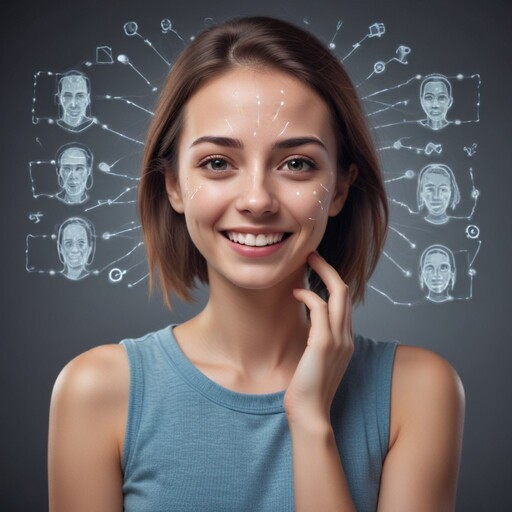

* Some of the numerical results in the explanation differ slightly from those shown, as the notebook was run multiple times. However, these differences are minor, so we chose to keep them as they are.


# Data collection

Data was collected directly from Kaggle , FER2013 dataset (Facial Expression Recognition 2013):
FER2013 is a dataset that consists of 35,887 labeled images depicting seven facial expressions -
**anger, disgust, fear, happiness, sadness, surprise, and neutral.**
It was created for the purposes of facial expression recognition research.

**link to the data :** https://www.kaggle.com/datasets/msambare/fer2013

In [9]:
import cv2
import os
!pip install imblearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import io
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from skimage.transform import rotate
from scipy.ndimage import rotate, shift
from skimage.transform import resize
!pip install mtcnn
from mtcnn import MTCNN
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import mode
import collections
from scipy.stats import norm
from skimage.feature import hog
from skimage import exposure
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from skimage.feature import hog
from skimage import exposure, io, transform
from sklearn.feature_selection import SelectKBest, f_classif
import random
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 56.0 MB/s eta 0:00:00


The "create_dataframe" function facilitates the process of converting image data organized in directories into a structured and analyzable format, making it easier to work with FER2013 dataset in machine learning and data analysis

In [10]:
def create_dataframe(root_dir):
    # Define emotion labels and mapping
    emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    label_mapping = {emotion: index for index, emotion in enumerate(emotions)}

    data = []

    for emotion in emotions:
        emotion_dir = os.path.join(root_dir, emotion)

        # Load images for the current emotion
        for image_file in os.listdir(emotion_dir):
            image_path = os.path.join(emotion_dir, image_file)
            image = cv2.imread(image_path)


            data.append((image_path, label_mapping[emotion]))

    df = pd.DataFrame(data, columns=['image_path', 'label'])

    return df


Before proceeding with further analysis, let's take a quick look at the structure and contents of our training dataset by inspecting the first few rows using the "head()" method

In [11]:
train_dir = "/content/train"
test_dir = "/content/test"
train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)
train_df.head()
pixel_columns = [f"pixel_{i}" for i in range(48*48)]

# EDA - Exploratory Data Analysis

let's visualize some sample images from different classes to get an idea of the data.

In [12]:
def display_sample_images(df, num_classes=7, num_samples_per_class=5):
    emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    fig, axes = plt.subplots(num_classes, num_samples_per_class, figsize=(15, 15))

    for i, emotion in enumerate(emotions):
        # Filter DataFrame for images belonging to the current emotion class
        emotion_images = df[df['label'] == i].sample(num_samples_per_class)['image_path'].values

        for j, image_path in enumerate(emotion_images):
            image = cv2.imread(image_path)
            axes[i, j].imshow(image)
            axes[i, j].set_title(emotion)
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()


Each row represents a different emotion class.
* emotion labels are provided as titles for each image.

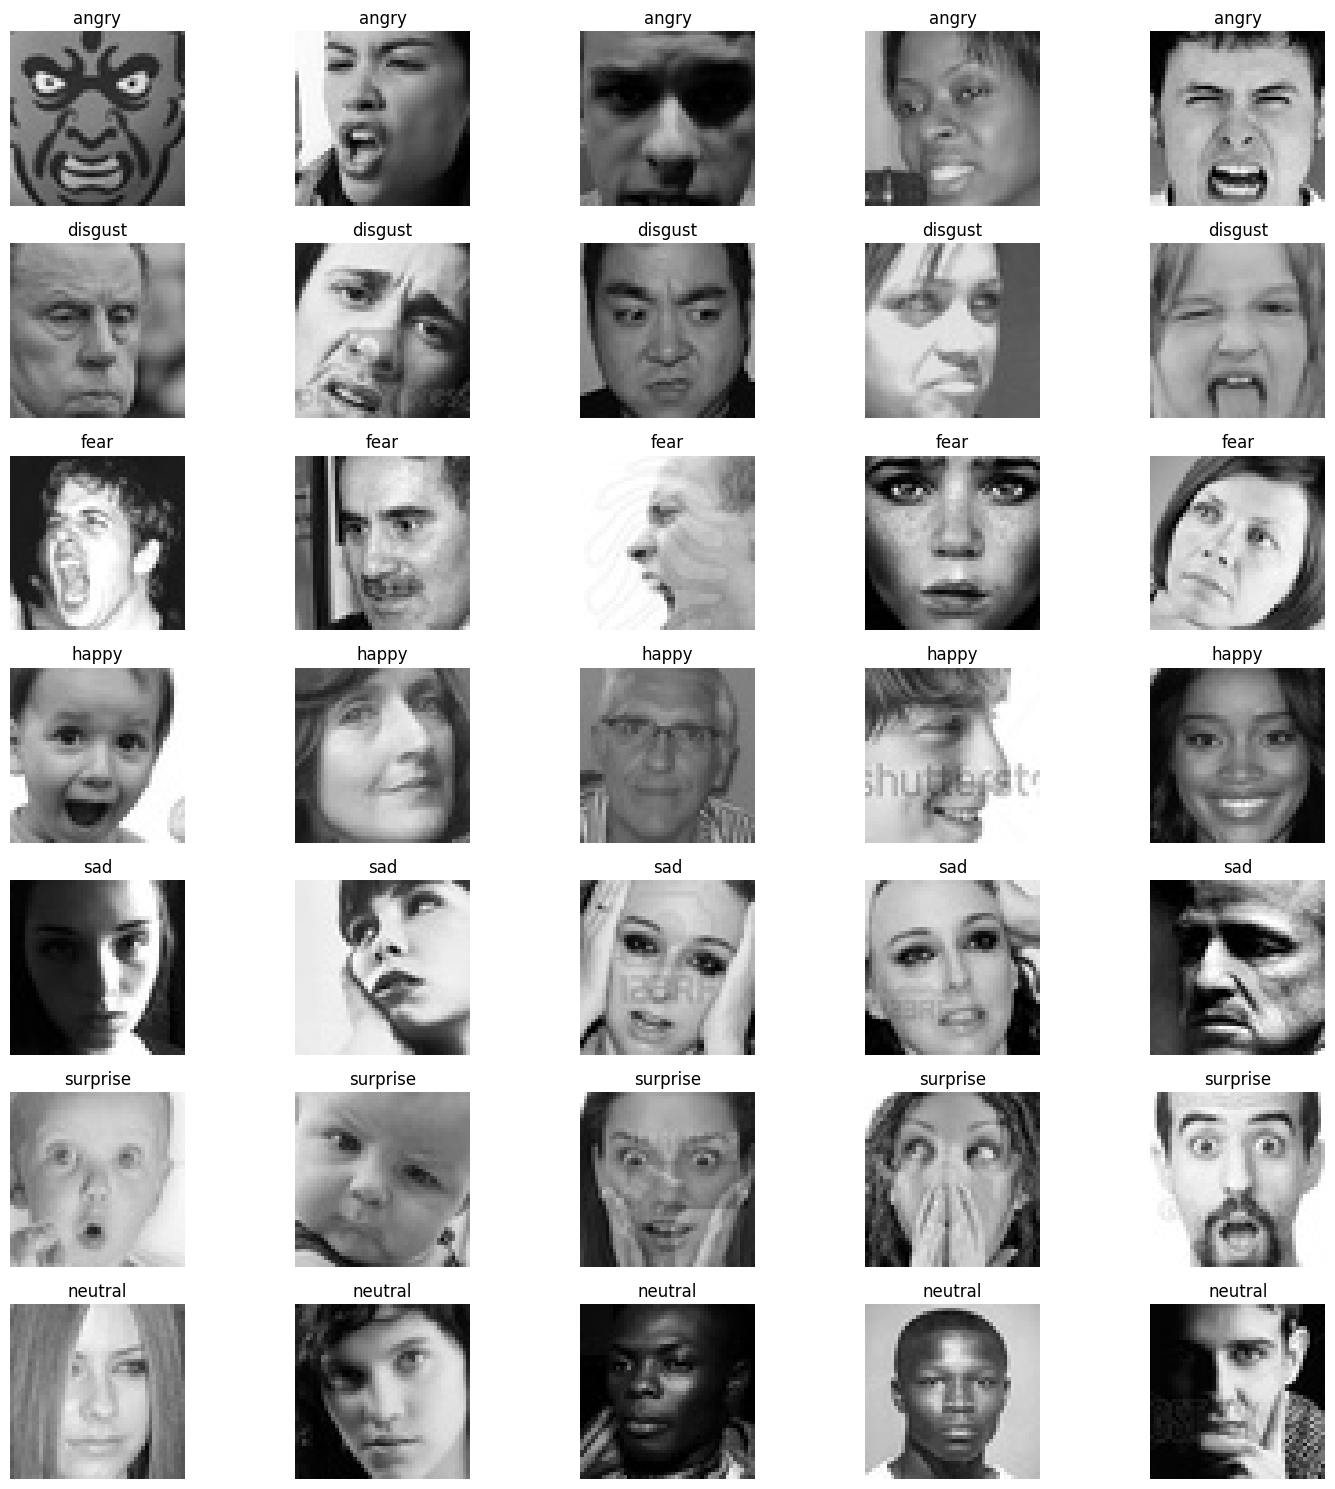

In [13]:
display_sample_images(train_df)

---
The following function gets a list of image paths as a parameter and returns a list where each element is a vector. This vector is a flattened representation of an image, each of which has a resolution of 48x48 pixels.

In [14]:
def load_and_preprocess_images(image_paths):
    images = []
    for path in image_paths:
        image = io.imread(path)
        images.append(image.flatten())
    return np.array(images)

---

Let's verify if our database includes any duplicate entries.


In [15]:
image_paths = train_df['image_path'].values
X = load_and_preprocess_images(image_paths)
# Find unique rows in X
unique_X, unique_indices = np.unique(X, axis=0, return_index=True)

print(len(unique_indices))
print(len(X))

# Check if there are duplicates
if len(unique_indices) == len(X):
    print("No duplicates found in X.")
else:
    print("Duplicates found in X.")

27473
28709
Duplicates found in X.


In [16]:
y = train_df['label'].values

The analysis reveals that there are 618 duplicated samples, calculated as half the difference between the total number of samples (28709) and the number of unique samples (27473). Next, we'll examine the classes of these duplicated samples. Based on the distribution of classes among the duplicates, we'll make an informed decision on whether to retain or remove them

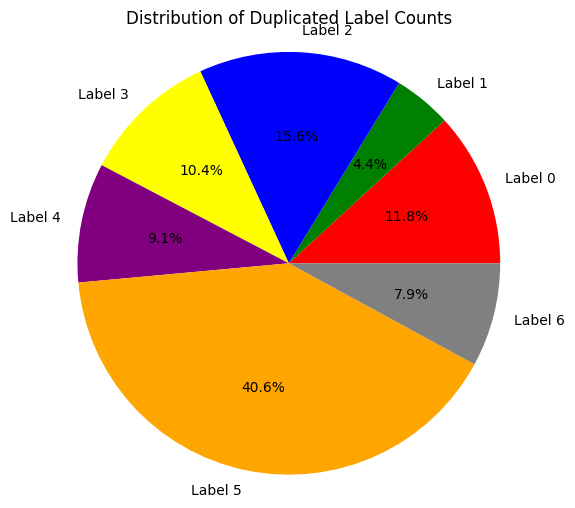

In [17]:
# Calculate the indices of duplicates
duplicated_indices = set(range(len(X))) - set(unique_indices)

# Extract the labels of duplicated samples
duplicated_labels = y[list(duplicated_indices)]

label_counts = np.bincount(duplicated_labels)

# Print the label counts
#for label, count in enumerate(label_counts):
    #print(f"Number of {label}s in duplicated_labels: {count}")

colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'gray']
labels = [f"Label {i}" for i in range(len(label_counts))]

# Plot the pie chart
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=labels, colors=colors[:len(label_counts)], autopct='%1.1f%%')
plt.title('Distribution of Duplicated Label Counts')
plt.axis('equal')
plt.show()


We've chosen not to delete the duplicate entries in the data for several  reasons :


*   **Class Imbalance :** Since most of the duplicates belong to class 5 (surprised face), which is not the dominant class and might need additional data for balance in the future, retaining the duplicates maintains a certain level of representation for this class. This approach aligns with the future plan of balancing categories and creating new data.
*   **Small Percentage of Duplicates:** The number of duplicates (618) relative to the total number of samples (28709) is relatively small 618/28709 = 0.021 , representing only a fraction of the dataset. Therefore, the impact of these duplicates on data quality and model performance is likely to be minimal.



---



let's analyze the brightness of the images by plotting a graph that shows brightness as a function of each image.

28709
28709


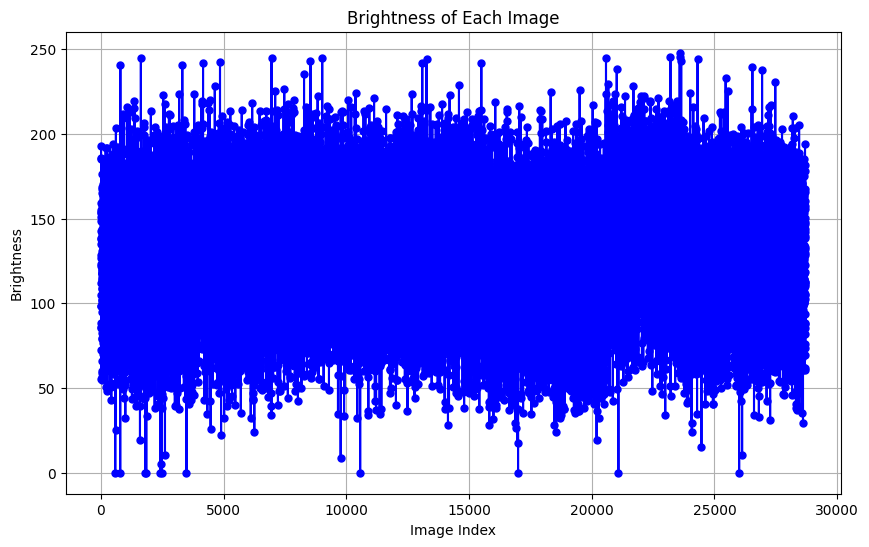

In [18]:
images = [cv2.imread(x) for x in train_df['image_path']]
print(len(images))
brightness_values = [np.mean(image) for image in images]
print(len(brightness_values))
plt.figure(figsize=(10, 6))
plt.plot(brightness_values, 'bo-', markersize=5)
plt.title('Brightness of Each Image')
plt.xlabel('Image Index')
plt.ylabel('Brightness')
plt.grid(True)
plt.show()


As observed in the  graph, there are anomalies in terms of brightness. To gain a clearer understanding of these exceptions, we will plot a graph showing the frequency (the number of samples) as a function of brightness. By doing this, we will get a better idea about the distribution of brightness values and more effectively identify and analyze the outliers.

Showing a graph of the brightness distribution can be very informative, as it allows us to see the overall distribution of brightness values in our dataset. This can help us identify any skewness, outliers, or unusual patterns that might indicate corrupted or abnormal images.

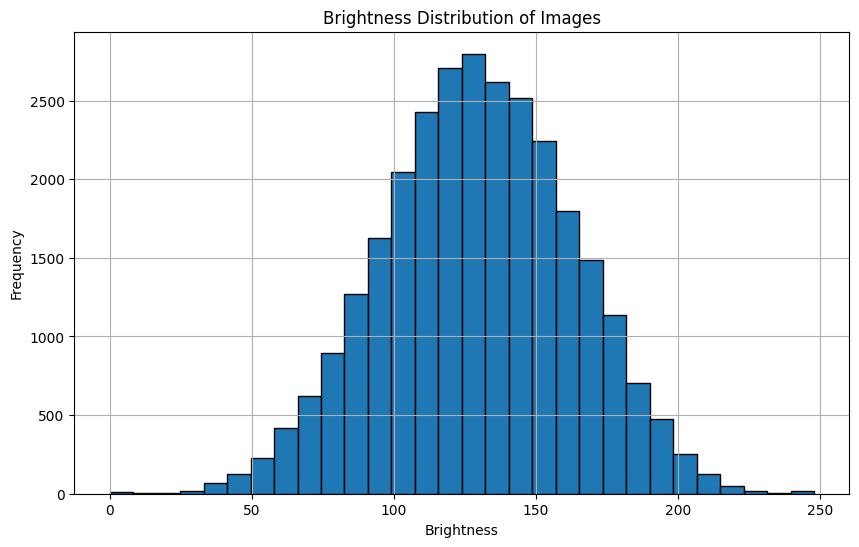

In [19]:
plt.figure(figsize=(10, 6))
plt.hist(brightness_values, bins=30, edgecolor='black')
plt.title('Brightness Distribution of Images')
plt.xlabel('Brightness')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

It looks like the brightness distribution resembles a normal distribution. To confirm this, we first calculate the mean and standard deviation of the brightness values, providing measures of central tendency and spread, respectively. Then, we create a histogram to visualize the distribution of brightness values across the dataset. Alongside the histogram, we overlay a theoretical normal distribution curve, which represents the expected distribution if the data were normally distributed. By comparing the histogram to the normal curve, we can assess the degree to which the brightness values conform to a normal distribution pattern.

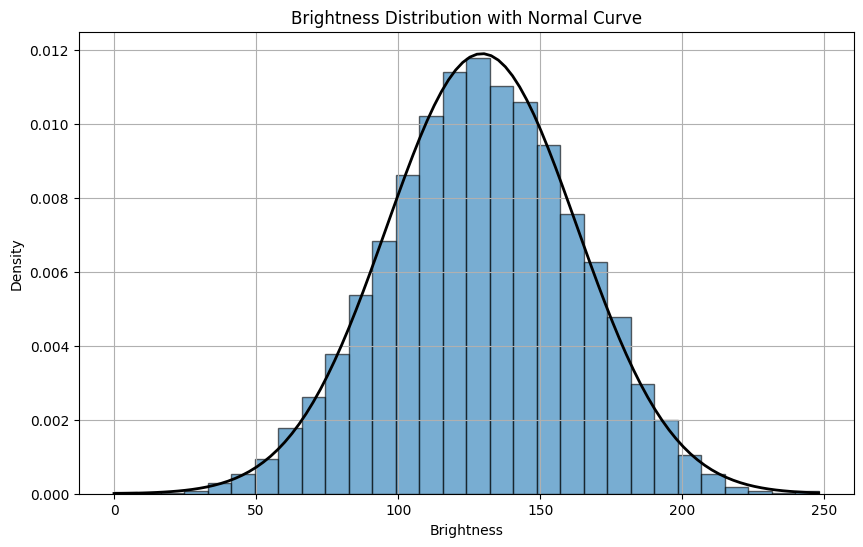

In [20]:
mean_brightness = np.mean(brightness_values)
std_brightness = np.std(brightness_values)

plt.figure(figsize=(10, 6))
plt.hist(brightness_values, bins=30, density=True, edgecolor='black', alpha=0.6)

x = np.linspace(min(brightness_values), max(brightness_values), 100)
p = norm.pdf(x, mean_brightness, std_brightness)
plt.plot(x, p, 'k', linewidth=2)

plt.title('Brightness Distribution with Normal Curve')
plt.xlabel('Brightness')
plt.ylabel('Density')
plt.grid(True)
plt.show()



Upon observing the alignment between the histogram and the theoretical normal distribution curve, it's evident that the brightness distribution closely resembles a normal distribution. This visual confirmation allows for further analysis, particularly in identifying outliers within the dataset.



---

Now, we'll employ a common visualization method: the box plot. This graphical representation offers a succinct summary of the dataset's central tendency, spread, and outlier presence. Below, you'll find a box plot showcasing the distribution of brightness values within our dataset. Each element of this plot unveils significant insights into the distribution: The box embodies the interquartile range (IQR), delineating where the middle 50% of data resides, while its lower and upper edges signify the first (Q1) and third (Q3) quartiles, respectively. Extending from the box, the whiskers portray the range of typical values, usually determined by a multiplier such as 1.5 times the IQR. Any data points lying beyond these whiskers are identified as outliers and are visualized as individual points.


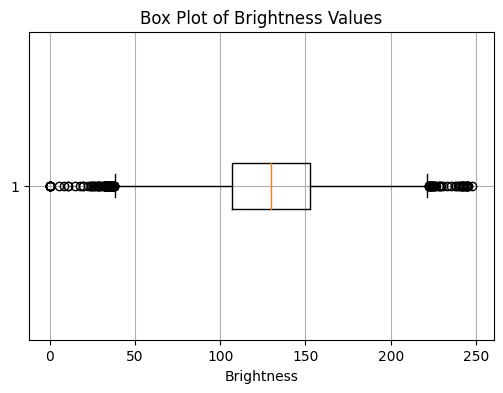

In [21]:
plt.figure(figsize=(6, 4))
plt.boxplot(brightness_values, vert=False)
plt.title('Box Plot of Brightness Values')
plt.xlabel('Brightness')
plt.grid(True)
plt.show()

We can observe that there are indeed exceptions in the data, as indicated by the points lying outside the box in the box plot. These points represent outliers, which are data values that significantly deviate from the rest of the dataset

 Outliers are identified through Z-scores, which represent the number of standard deviations away from the mean each brightness value is. In this method, Z-scores exceeding a threshold, commonly set to 3, are considered outliers.
 The identification of outliers is pivotal in maintaining the accuracy and reliability of subsequent statistical analyses and modeling techniques applied to the dataset.

In [22]:
mean_brightness = np.mean(brightness_values)
std_brightness = np.std(brightness_values)

z_scores = (brightness_values - mean_brightness) / std_brightness
# Find the indices of outliers
outlier_indices = np.where(np.abs(z_scores) > 3)[0]


Now, we will present some images that are identified as outliers. These images have brightness values that significantly deviate from the rest of the dataset.

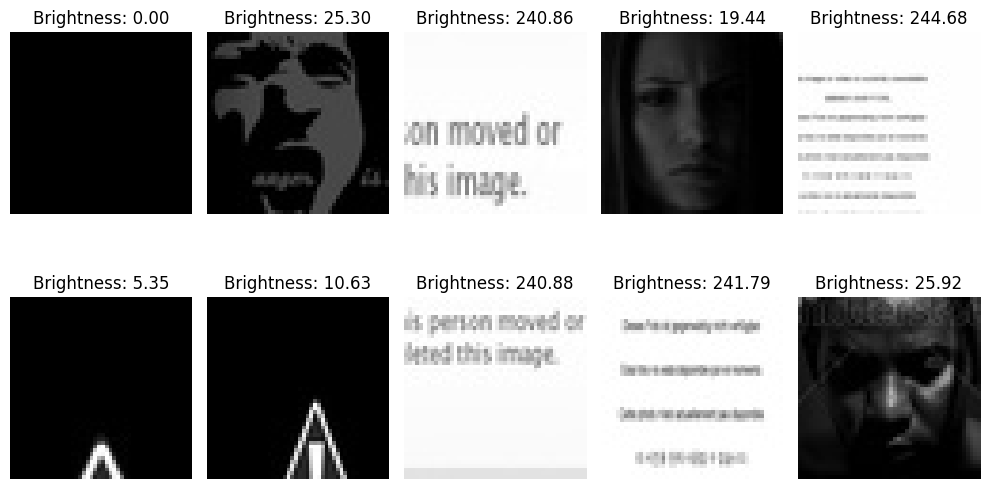

In [23]:
unique_brightness_values = []
unique_images = []


#print(len(brightness_values))

for i in outlier_indices:
    brightness = brightness_values[i]
    if brightness not in unique_brightness_values:
        unique_brightness_values.append(brightness)
        unique_images.append(images[i])
    # Stop after collecting 10 unique outliers
    if len(unique_brightness_values) >= 10:
        break

fig, axes = plt.subplots(2, 5, figsize=(10, 6))
axes = axes.flatten()

for i, image in enumerate(unique_images[:10]):
    axes[i].imshow(image)
    brightness_str = f"{unique_brightness_values[i]:.2f}"
    axes[i].set_title(f"Brightness: {brightness_str}")
    axes[i].axis('off')

for i in range(len(unique_images), 10):
    axes[i].axis('off')

plt.tight_layout()
plt.show()



we can see that the pictures are corrupted ,  there are completely black pictures, completely white pictures, and some that are mostly black or white with a few stripes. Some of the pictures do not represent a face at all, and others are very difficult to recognize due to the brightness.
In addition, these samples do not contribute to the learning of the algorithm in the face recognition application and constitute noise. Therefore, we will omit these images from the dataset.







In [24]:
train_df = train_df.drop(outlier_indices)

Let's explore the distribution of classes (emotional expressions). Are they balanced or skewed?

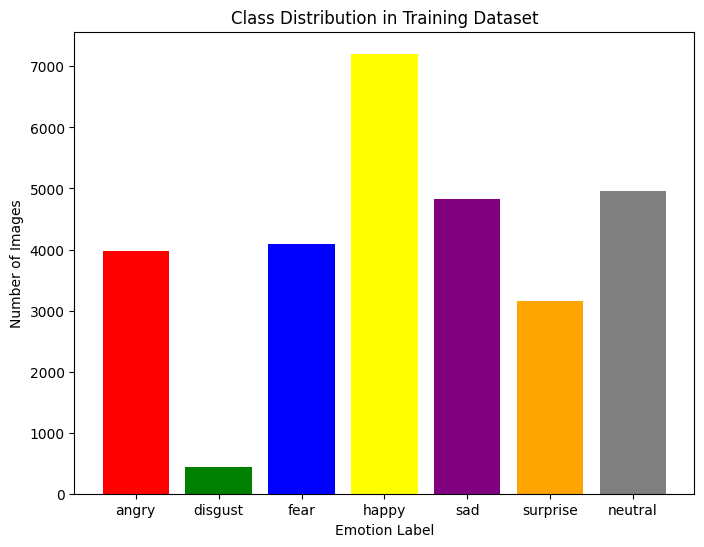

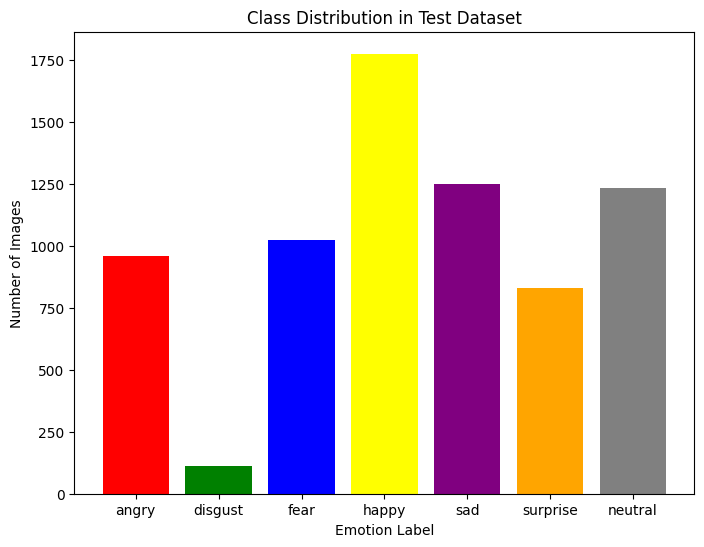

In [25]:
def plot_class_distribution(df, dataset_name):
    emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'gray']

    class_counts = df['label'].value_counts()
    plt.figure(figsize=(8, 6))
    plt.bar(class_counts.index, class_counts.values, color=[colors[label] for label in class_counts.index])
    plt.title(f'Class Distribution in {dataset_name}')
    plt.xlabel('Emotion Label')
    plt.ylabel('Number of Images')
    plt.xticks(list(range(len(emotions))), emotions)
    plt.show()

# Plot class distribution for training dataset
plot_class_distribution(train_df, 'Training Dataset')

# Plot class distribution for test dataset
plot_class_distribution(test_df, 'Test Dataset')

In our dataset, there is a noticeable imbalance, with a significantly larger number of samples representing one class compared to another. For instance, we observe 7215 samples associated with the "happy" class, while only 436 samples are attributed to the "disgusted" class. Such an imbalance can skew the learning process of our model, potentially leading to biased predictions favoring the majority class.




# **Feature Extraction**


In this section, we will extract features from the facial images in our dataset using the Histogram of Oriented Gradients (HOG) method. HOG is a feature descriptor that highlights edges and changes in intensity by computing the gradient of image intensity in both horizontal and vertical directions. It then compiles histograms of gradient directions for small spatial regions, normalizes these within larger blocks, and generates a feature vector. By applying HOG to each 48x48 pixel grayscale image in the FER2013 dataset, we transform the raw pixel data into meaningful feature vectors. These vectors capture essential structural information, making them suitable for our task: facial expression classification.

In [26]:
def extract_hog_features(images):
    hog_features = []
    for image in images:
        fd = hog(image.reshape((48, 48)), orientations=9, pixels_per_cell=(8, 8),
                 cells_per_block=(2, 2), visualize=False, transform_sqrt=True, block_norm='L1')
        hog_features.append(fd)
    return np.array(hog_features)
train_images = load_and_preprocess_images(train_df['image_path'])
train_features = extract_hog_features(train_images)


In [27]:
def extract_hog_features_hog_images(images):
    hog_features = []
    hog_images = []
    for image in images:
        fd, hog_image = hog(image.reshape((48, 48)), orientations=9, pixels_per_cell=(8, 8),
                            cells_per_block=(2, 2), visualize=True, transform_sqrt=True, block_norm='L1')
        hog_features.append(fd)
        hog_images.append(hog_image)
    return np.array(hog_features), np.array(hog_images)
train_images = load_and_preprocess_images(train_df['image_path'])
train_features , hog_images = extract_hog_features_hog_images(train_images)


To ensure the effectiveness of the HOG feature extraction, we will visualize the HOG features alongside the original images. The following function, visualize_hog_features, selects a sample of images, computes their HOG features, and displays each original image next to its HOG feature representation. This visualization helps us verify that the HOG features are capturing the essential edge and gradient information from the images, which is crucial for our task.

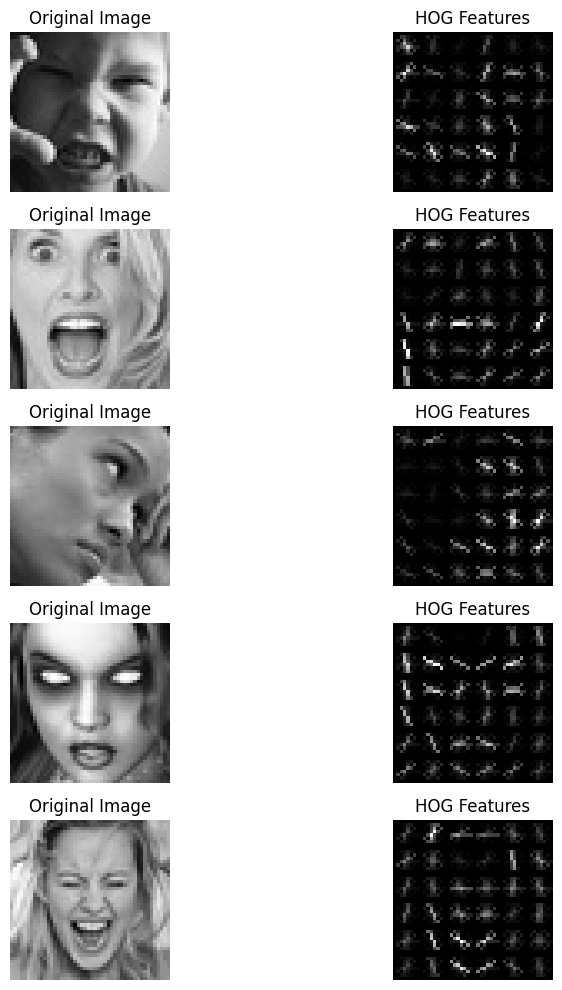

In [28]:
def visualize_hog_features(train_features,hog_images, num_samples=5 , selected_features=None):

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 2 * num_samples))
    for i in range(num_samples):
        fd = train_features[i]
        hog_image = hog_images[i]
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        train_image_reshaped = np.expand_dims(train_images[i], axis=0)

        axes[i, 0].imshow(train_images[i].reshape((48, 48)), cmap=plt.cm.gray)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(hog_image_rescaled, cmap=plt.cm.gray)
        axes[i, 1].set_title('HOG Features')
        axes[i, 1].axis('off')

        if selected_features is not None:
            for feature in selected_features:
                row, col = divmod(feature, hog_image_rescaled.shape[1])
                axes[i, 1].plot(col, row, 'ro')

    plt.tight_layout()
    plt.show()

visualize_hog_features(train_features,hog_images)


The images above illustrate the process and results of applying HOG feature extraction to the images in our dataset. On the left side, we see the original grayscale images, which serve as the input for the HOG feature extraction. On the right side, the corresponding HOG feature visualizations are displayed. These visualizations highlight the gradient and edge information within the images, with bright areas indicating strong gradients that correspond to edges and structural details in the original images.

In [29]:
def visualize_hog_features(images, hog_images, num_samples=1, selected_features=None):
    sample_images = images[:num_samples]
    sample_hog_images = hog_images[:num_samples]

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 2 * num_samples))
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, (image, hog_image) in enumerate(zip(sample_images, sample_hog_images)):
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

        axes[i, 0].imshow(train_images[i].reshape((48, 48)), cmap=plt.cm.gray)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(hog_image_rescaled, cmap=plt.cm.gray)
        axes[i, 1].set_title('HOG Features')
        axes[i, 1].axis('off')

        if selected_features is not None:
            for feature in selected_features:
                row, col = divmod(feature, hog_image_rescaled.shape[1])
                axes[i, 1].plot(col, row, 'ro')

    plt.tight_layout()
    plt.show()



In this section, we utilize statistical methods to visualize the most relevant features from the dataset. Using SelectKBest with the ANOVA F-score (f_classif), we evaluate and rank features based on their importance for predicting the target variable. The ANOVA F-score assesses the statistical significance of each feature by comparing between-group and within-group variance. We set k=10 to select the top 10 features, fit the model, and transform the dataset accordingly. The indices of these selected features are identified and visualized to understand their spatial significance on the images. Finally, we print the importance scores of these features, which helps simplify the model and enhance its interpretability by focusing on the most critical features for classification.

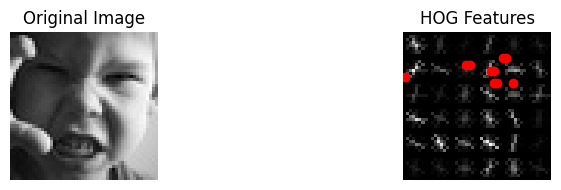

feature_416: 198.45013473850443
feature_417: 186.1608592557203
feature_500: 229.03463861880684
feature_501: 223.52759815894146
feature_604: 188.40693941497204
feature_605: 202.19079971419677
feature_672: 196.0584674078814
feature_797: 203.11116433173066
feature_798: 188.06747307547042
feature_803: 191.89440612286347


In [30]:
train_labels = train_df['label'].values

# Select top k features based on F-score
selector = SelectKBest(f_classif, k=10)
X_selected = selector.fit_transform(train_features, train_labels)

selected_feature_indices = selector.get_support(indices=True)

# Visualize the selected features
visualize_hog_features(train_images, hog_images, num_samples=1, selected_features=selected_feature_indices)

selected_feature_names = [f"feature_{i}" for i in selected_feature_indices]
for i, feature_name in enumerate(selected_feature_names):
    importance = selector.scores_[selected_feature_indices[i]]
    print(f"{feature_name}: {importance}")


we can see that the ten most decisive characteristics are concentrated around the right eye area. To further explore the nuances of emotional expression, we endeavor to expand our scope to one hundred significant characteristics. This broader examination aims to reveal the main area responsible for emotional disclosure and verify its logical coherence.

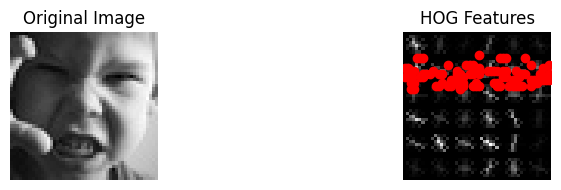

In [31]:
# Select top 100 features based on F-score
selector = SelectKBest(f_classif, k=100)
X_selected = selector.fit_transform(train_features, train_labels)

selected_feature_indices = selector.get_support(indices=True)

visualize_hog_features(train_images, hog_images, num_samples=1, selected_features=selected_feature_indices)

Based on the results obtained, the area around the eyes and eyebrows emerges as the most critical, as all significant features are concentrated there. This finding aligns logically with our understanding of emotional expression, where the eyes and eyebrows play a pivotal role. Interestingly, while the mouth area is also crucial for conveying emotions, it did not exhibit any significant features in this analysis.



---


Let's try extracting features using the pre-trained VGG16 model, known for its high performance in image classification tasks.
To prepare our images for VGG16, we resize, crop, and normalize them. We then create a function to preprocess and extract features from the images using VGG16. and Since VGG16 works with RGB images, we convert our grayscale images to RGB format. Finally, we use VGG16 to extract features from these selected images. This process helps us identify and analyze the most important regions of the images for emotion detection and we can compare the results to HOG.

In [32]:
model = models.vgg16(pretrained=True)
model.eval()

# Preprocess function for VGG16
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def extract_features_vgg(images, model):
    all_features = []
    processed_images = []
    for image in images:
        image = Image.fromarray(image)
        input_tensor = preprocess(image)
        input_batch = input_tensor.unsqueeze(0)
        if torch.cuda.is_available():
            input_batch = input_batch.to('cuda')
            model.to('cuda')
        with torch.no_grad():
            features = model.features(input_batch)
        features_numpy = features.squeeze().cpu().numpy()

        all_features.append(features_numpy)
        processed_images.append(image)
    return np.array(all_features), processed_images

train_images_reshaped = train_images.reshape(-1, 48, 48)

images_rgb = [cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) for img in train_images_reshaped]

train_features2, processed_train_images2 = extract_features_vgg(images_rgb, model)

print(train_images_reshaped.shape)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 90.5MB/s]


(28657, 48, 48)


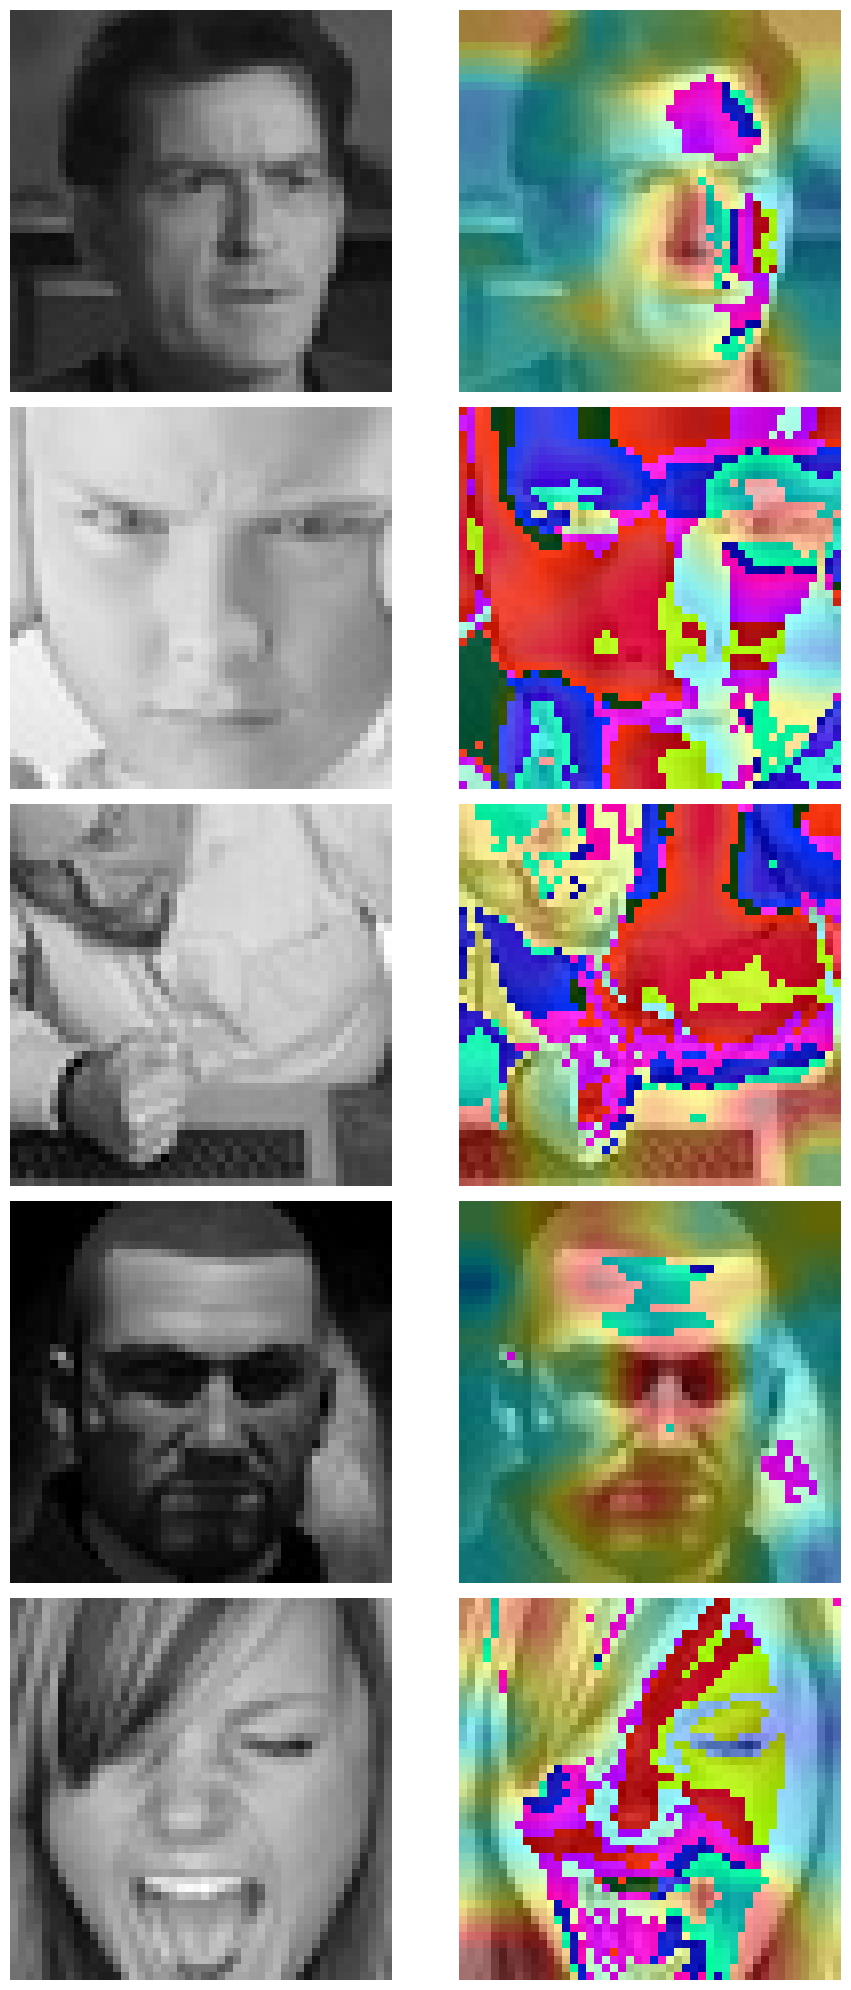

In [33]:
selected_images = [train_images_reshaped[i] for i in range(20, 25)]

selected_images_rgb = [cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) for img in selected_images]
train_features, processed_train_images = extract_features_vgg(selected_images_rgb, model)

fig, axes = plt.subplots(len(processed_train_images), 2, figsize=(10, 4 * len(processed_train_images)))

for i, (image, features) in enumerate(zip(processed_train_images, train_features)):
    axes[i, 0].imshow(image)
    axes[i, 0].axis('off')

    # Display the extracted features as a heatmap
    feature_map = features.mean(axis=0)  # Average the feature maps across the depth
    heatmap = cv2.resize(feature_map, (image.size[0], image.size[1]))
    heatmap = np.maximum(heatmap, 0)  # Apply ReLU to the heatmap to remove negative values
    heatmap /= heatmap.max()  # Normalize the heatmap to be in the range [0, 1]
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)  # Apply color map to the heatmap
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert the heatmap from BGR to RGB
    superimposed_img = heatmap * 0.4 + np.array(image)  # Superimpose the heatmap on the original image

    axes[i, 1].imshow(superimposed_img.astype('uint8'))
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


Let's analyze the results. First of all, let's present the meaning of the colors in the heatmap:

**Heatmap Colors and Their Meaning:**


*   **Red Areas:** Indicate high activation levels. These regions are considered the most important by the VGG16 model for identifying features relevant to the task. In this case, these areas are likely crucial for emotion detection.
*   **Yellow to Green Areas:** Represent moderate activation. These regions have some importance but are not as critical as the red areas.

*   **Blue Areas:** Indicate low activation levels. These regions are considered less significant by the model.


Now, let's examine the specific images and their corresponding heatmaps.
The heatmaps generated from the VGG16 model highlight the critical areas used for emotion detection in facial expressions. Red regions indicate high activation levels, suggesting these areas are most important to the model. Across all images, the eyes and eyebrows consistently show high activation, indicating these regions are the most significant for emotion detection by the VGG16 model. This aligns with psychological studies that emphasize the role of eye expressions in conveying emotions. There is some activation around the nose and mouth, but it is generally less intense compared to the eyes and eyebrows, indicating that the model recognizes these areas as moderately important. The results are logically coherent, as the eyes, eyebrows, and to some extent, the mouth are well-known areas for detecting emotional expressions. The absence of significant activation in other areas (like cheeks or forehead) aligns with the understanding that these regions are less expressive of emotions.

**comparing the results of VGG16 to HOG feature selection:**

**Eyes and Eyebrows:**

VGG16: High activation, indicating these regions are crucial for emotion detection.
HOG (SelectKBest): The top 100 features selected also show significant importance in the area around the eyes, confirming the importance of these regions.

**Nose and Mouth:**

VGG16: Moderate activation around the nose and mouth.
HOG (SelectKBest): Some features around the mouth area were selected, but fewer compared to the eyes and eyebrows, aligning with VGG16's emphasis on the eyes.

Overall, the comparison shows that while both VGG16 and HOG feature selection converge on similar conclusions about the importance of the eyes and eyebrows in emotion detection, VGG16 places more emphasis on the mouth area than HOG. This indicates that VGG16 might be capturing more nuanced expressions that involve the mouth, providing a more comprehensive analysis of facial expressions for emotion detection.

---


To address the class imbalance problem , we intend to employ a  technique known as Synthetic Minority Over-sampling Technique (SMOTE) . SMOTE works by generating synthetic samples in the minority class, thus equalizing the representation of both classes. This helps to alleviate the class imbalance problem by artificially increasing the number of minority class samples.

In [34]:
# Load and preprocess images
image_paths = train_df['image_path'].values
Xt = load_and_preprocess_images(image_paths)
yt = train_df['label'].values

# Apply SMOTE to balance the dataset
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(Xt, yt)
print(len(X_resampled))
print(len(y_resampled))

# Combine resampled features and labels
preprocess_train_df = pd.DataFrame(X_resampled, columns=[f"pixel_{i}" for i in range(X_resampled.shape[1])])
preprocess_train_df['label'] = y_resampled


# Check the class distribution after resampling
print("Class distribution after resampling:")
print(preprocess_train_df['label'].value_counts())

50449
50449
Class distribution after resampling:
label
0    7207
1    7207
2    7207
3    7207
4    7207
5    7207
6    7207
Name: count, dtype: int64


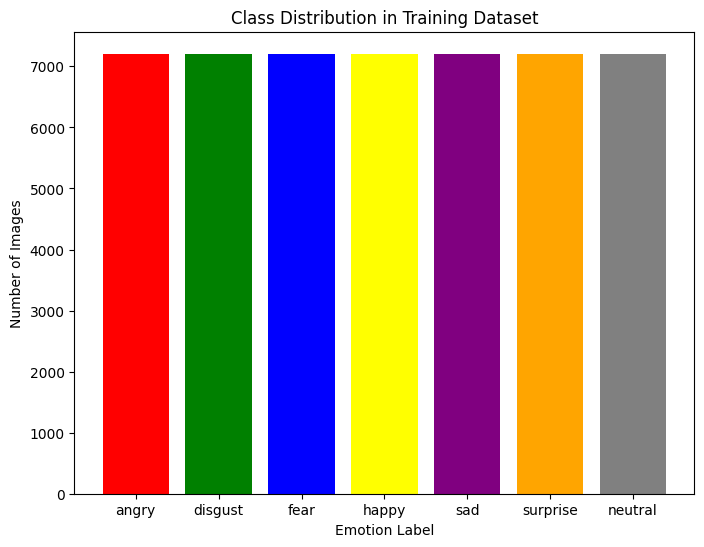

In [35]:
plot_class_distribution(preprocess_train_df, 'Training Dataset')

Let's visualize a selection of sample images from various classes within the dataset after applying the SMOTE algorithm to balance it, thereby assessing the quality of the balanced dataset.

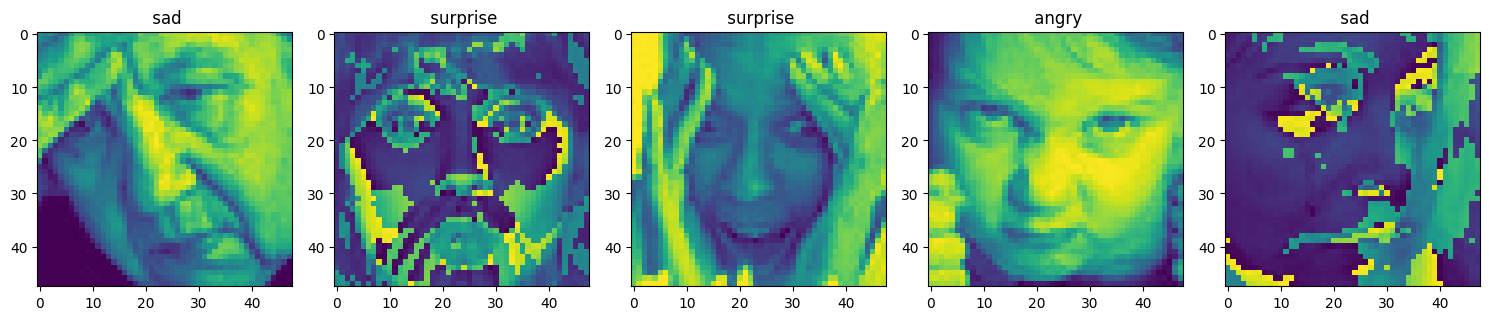

In [36]:
num_samples_to_display = 5
emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Randomly select some sample indices
sample_indices = np.random.choice(preprocess_train_df.shape[0], num_samples_to_display, replace=False)

# Create a subplot grid
fig, axes = plt.subplots(1, num_samples_to_display, figsize=(15, 3))

for i, idx in enumerate(sample_indices):
    image_data = preprocess_train_df.iloc[idx, :-1].values.reshape(48, 48)
    label = preprocess_train_df.iloc[idx, -1]
    axes[i].imshow(image_data)
    axes[i].set_title(f" {emotions[label]}")

plt.tight_layout()
plt.show()

We made several iterations of this section, Upon careful examination of the facial images, it became evident that certain newly generated images exhibited noise, characterized by inconsistencies in certain pixels. This outcome was anticipated due to the application of SMOTE, which can introduce noise in generated samples. Nevertheless, it is noteworthy that a notable correlation persists between the newly created samples and their respective emotion classifications.

# **Clustring**

In this part of the analysis, we aim to explore the potential of clustering techniques to uncover patterns and groupings within our facial emotion recognition dataset. Clustering is an unsupervised learning approach that partitions the data into distinct groups or clusters based on similarities among the data points.
By applying clustering to our dataset of flattened images, we can potentially identify natural groupings of facial expressions that may correspond to different emotional states. This approach can provide valuable insights into the underlying structure of the data and help us better understand the relationships between various emotional expressions.

In our analysis, we will be using the K-Means clustering algorithm, which is a widely used and well-established technique for partitioning data into distinct clusters. K-Means iteratively assigns data points to clusters based on their proximity to cluster centroids, with the goal of minimizing the sum of squared distances between data points and their assigned cluster centroids.
Before applying K-Means clustering, we will perform Principal Component Analysis (PCA) to reduce the dimensionality of our flattened image data. PCA is a linear transformation technique that projects the high-dimensional data onto a lower-dimensional subspace while preserving as much of the original variance as possible. This step is crucial for improving the computational efficiency of the clustering algorithm and potentially revealing underlying patterns that may be obscured in the original high-dimensional space.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


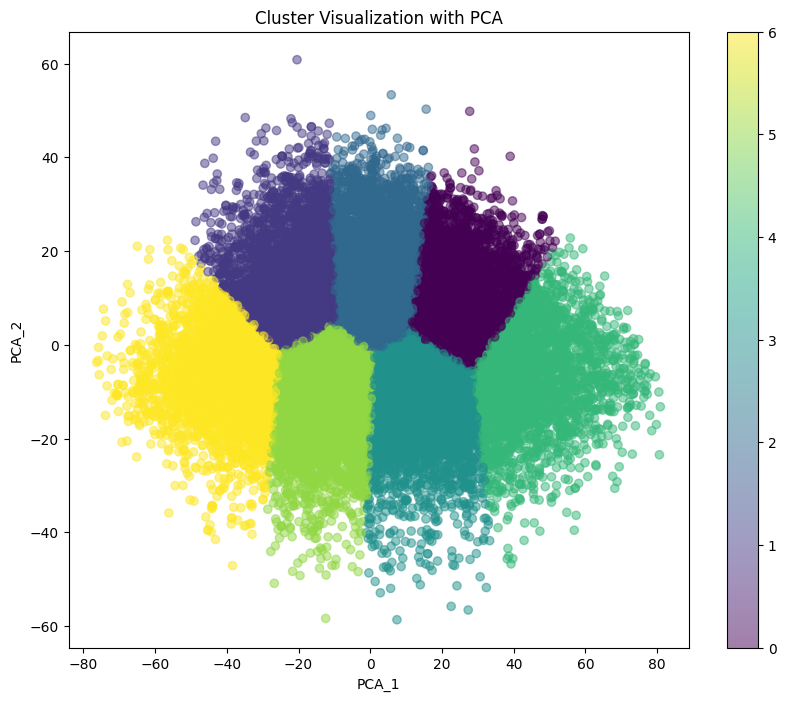

In [37]:

image_paths = train_df['image_path'].values
data = load_and_preprocess_images(image_paths)

scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)

pca = PCA(n_components=2)  # Adjust to 2 dimentions
images_reduced = pca.fit_transform(normalized_data)

# Apply K-means clustering
k = 7  # Suppose 7 clusters one for each emotion.
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(images_reduced)

# Plotting the results
plt.figure(figsize=(10, 8))
plt.scatter(images_reduced[:, 0], images_reduced[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.colorbar(ticks=range(k))
plt.title('Cluster Visualization with PCA')
plt.xlabel('PCA_1')
plt.ylabel('PCA_2')
plt.show()

In [38]:
def analyze_clusters(clusters):
  label_frequencies = collections.defaultdict(lambda: collections.defaultdict(int))

  label_mapping = {
      0: 'angry',
      1: 'disgust',
      2: 'fear',
      3: 'happy',
      4: 'sad',
      5: 'surprise',
      6: 'neutral'
  }
  classes = train_df['label'].values #real labels
  print(len(classes))
  for data_idx, cluster in enumerate(clusters):
      label = classes[data_idx]
      label_frequencies[cluster][label] += 1
  for key, value in label_frequencies.items():
    print(f"{key}: {value}")


  for cluster, emotion in label_frequencies.items():
      max_emotion = max(emotion, key=emotion.get)
      print(f"For cluster emotion-dict {cluster}, the most common emotion is {label_mapping[max_emotion]}")

  return label_frequencies

In [39]:
def plot_clustering_results(clusters):
  label_frequencies = analyze_clusters(clusters)
  label_mapping = {
      0: 'angry',
      1: 'disgust',
      2: 'fear',
      3: 'happy',
      4: 'sad',
      5: 'surprise',
      6: 'neutral'
  }
  # Prepare data for plotting
  data = []
  for cluster, emotion_counts in label_frequencies.items():
      for emotion, count in emotion_counts.items():
          data.append({'Cluster': cluster, 'Emotion': label_mapping[emotion], 'Count': count})

  # Convert to DataFrame
  df = pd.DataFrame(data)

  # Plotting
  plt.figure(figsize=(12, 8))
  sns.barplot(data=df, x='Cluster', y='Count', hue='Emotion')
  plt.title('Emotion Distribution Across Clusters')
  plt.xlabel('Cluster')
  plt.ylabel('Count')
  plt.legend(title='Emotion')
  plt.show()

28657
3: defaultdict(<class 'int'>, {0: 739, 1: 71, 2: 690, 3: 1167, 4: 985, 5: 288, 6: 806})
5: defaultdict(<class 'int'>, {0: 830, 1: 71, 2: 959, 3: 1101, 4: 892, 5: 684, 6: 737})
2: defaultdict(<class 'int'>, {0: 638, 1: 86, 2: 601, 3: 1513, 4: 711, 5: 518, 6: 952})
0: defaultdict(<class 'int'>, {0: 511, 1: 47, 2: 389, 3: 1031, 4: 676, 5: 223, 6: 736})
6: defaultdict(<class 'int'>, {0: 389, 1: 81, 2: 668, 3: 817, 4: 412, 5: 773, 6: 461})
4: defaultdict(<class 'int'>, {0: 462, 1: 30, 2: 267, 3: 573, 4: 755, 5: 106, 6: 646})
1: defaultdict(<class 'int'>, {0: 412, 1: 49, 2: 517, 3: 1005, 4: 392, 5: 572, 6: 618})
For cluster emotion-dict 3, the most common emotion is happy
For cluster emotion-dict 5, the most common emotion is happy
For cluster emotion-dict 2, the most common emotion is happy
For cluster emotion-dict 0, the most common emotion is happy
For cluster emotion-dict 6, the most common emotion is happy
For cluster emotion-dict 4, the most common emotion is sad
For cluster emot

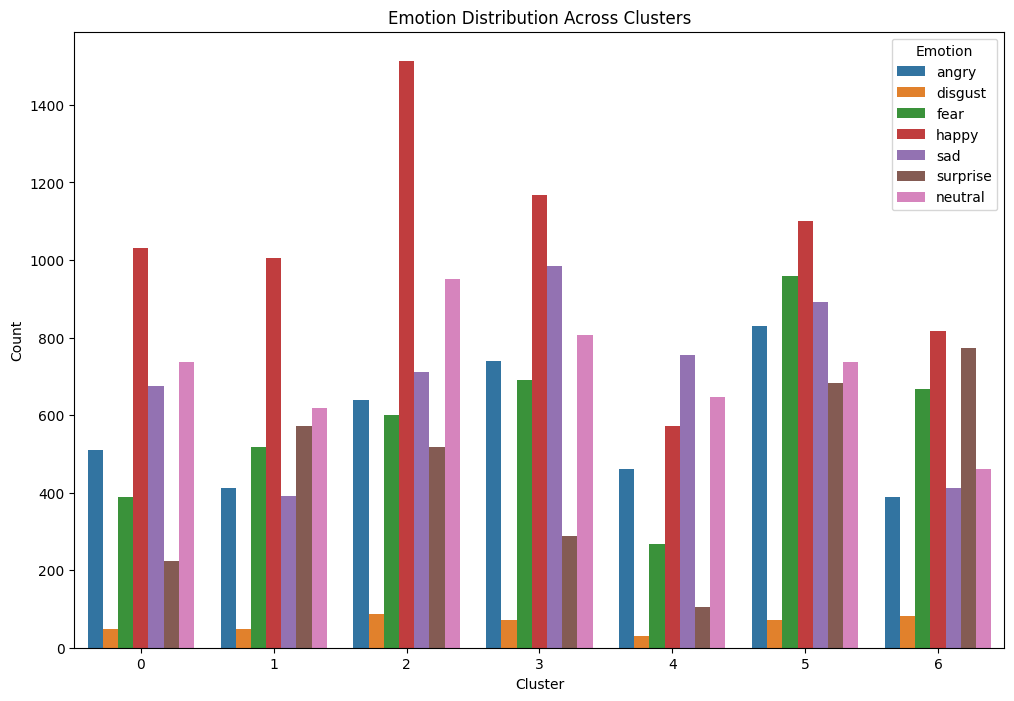

In [40]:
plot_clustering_results(clusters)

The analysis consistently showed that the dominant emotion across almost all clusters was "happy". This outcome raises a couple of crucial points regarding both the data and the methodological approach.

Imbalanced Dataset: The data may exhibit a substantial skew towards "happy" emotion images. Such an imbalance can heavily influence the clustering process, resulting in most clusters predominantly reflecting the "happy" emotion due to its higher prevalence.

Algorithmic Limitations: The consistent dominance of the "happy" emotion across various algorithmic trials suggests that the K-Means algorithm, along with the PCA setup used, may not be adequately capturing the subtle differences between diverse emotion categories. This could be due to the inherent limitations of K-Means in dealing with complex and nuanced data structures typically found in emotion recognition tasks.

Let's try to improve the clustering results first by selecting the number of dimensions for PCA more intelligently. Let's use the elbow method to determine the optimal number of dimensions—this involves identifying the point at which adding more dimensions no longer provides significant additional information.

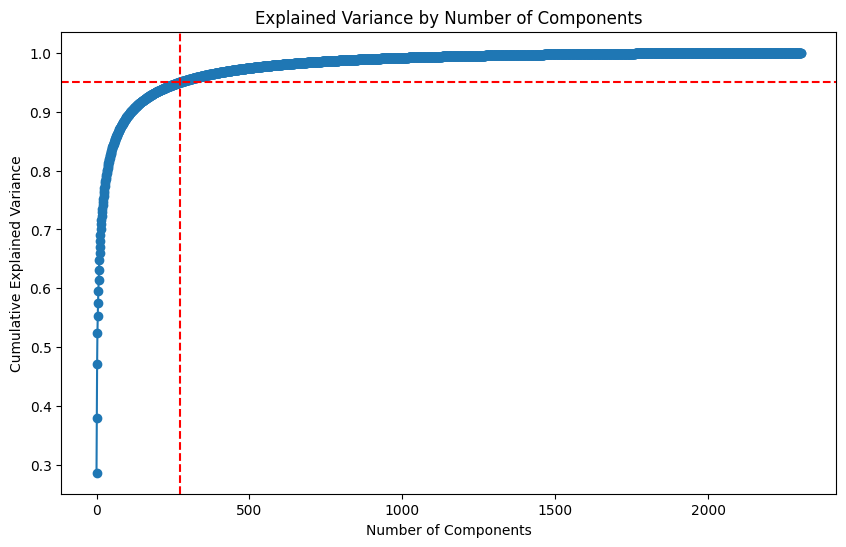

Number of components to retain 95% variance: 274


In [41]:
pca = PCA().fit(normalized_data)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.axvline(x=np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95), color='r', linestyle='--')
plt.show()

# Print the number of components to retain 95% variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Number of components to retain 95% variance: {n_components}")

As illustrated in the plot, retaining 273 components captures 95% of the data's variance. This indicates that by keeping these 273 principal components, we preserve the majority of the essential information in the dataset while effectively reducing its dimensionality.

In contrast, our previous attempt using only 2 components resulted in significant information loss.

Let's proceed with clustering using 273 components to improve the results.

In [42]:
pca_274 = PCA(n_components=274)  # pca_273 - because we keep 95% of explained variance.
images_reduced = pca_274.fit_transform(normalized_data)
# image reduced keep the new image list after dimention reduction using pca

# Apply K-means clustering
k = 7  # Suppose 7 clusters one for each emotion.
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(images_reduced)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


28657
0: defaultdict(<class 'int'>, {0: 712, 1: 57, 2: 558, 3: 1054, 4: 833, 5: 223, 6: 661})
2: defaultdict(<class 'int'>, {0: 673, 1: 62, 2: 809, 3: 923, 4: 694, 5: 607, 6: 672})
6: defaultdict(<class 'int'>, {0: 613, 1: 52, 2: 584, 3: 891, 4: 758, 5: 374, 6: 586})
5: defaultdict(<class 'int'>, {0: 550, 1: 89, 2: 610, 3: 1356, 4: 522, 5: 618, 6: 797})
4: defaultdict(<class 'int'>, {0: 405, 1: 44, 2: 383, 3: 1226, 4: 608, 5: 309, 6: 847})
1: defaultdict(<class 'int'>, {0: 451, 1: 90, 2: 762, 3: 981, 4: 488, 5: 896, 6: 570})
3: defaultdict(<class 'int'>, {0: 577, 1: 41, 2: 385, 3: 776, 4: 920, 5: 137, 6: 823})
For cluster emotion-dict 0, the most common emotion is happy
For cluster emotion-dict 2, the most common emotion is happy
For cluster emotion-dict 6, the most common emotion is happy
For cluster emotion-dict 5, the most common emotion is happy
For cluster emotion-dict 4, the most common emotion is happy
For cluster emotion-dict 1, the most common emotion is happy
For cluster emot

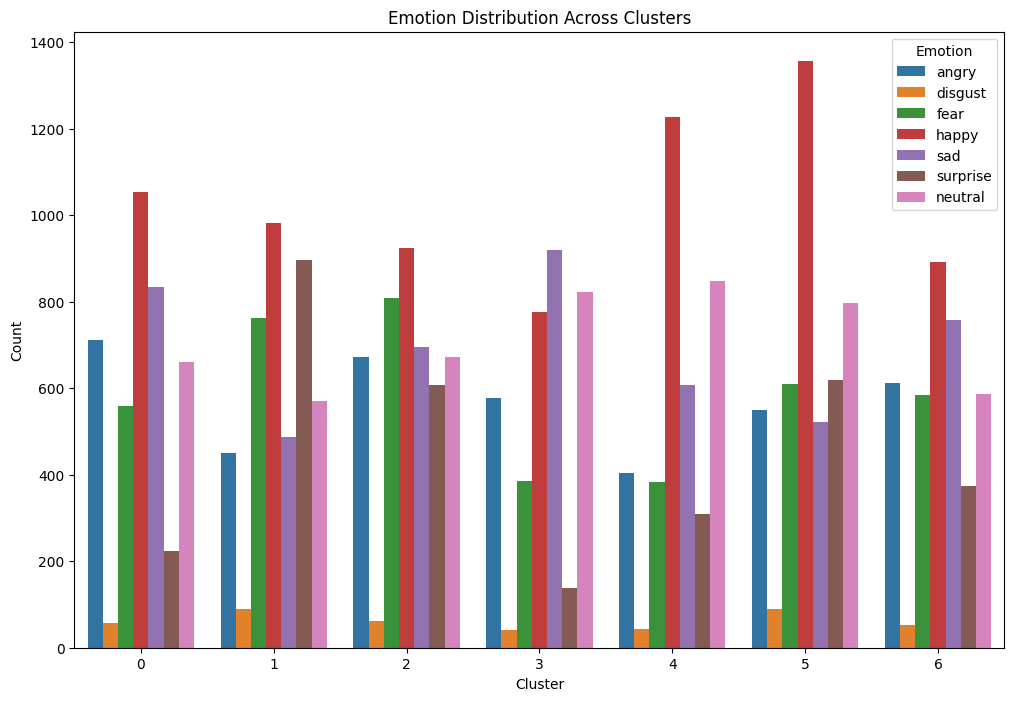

In [43]:
plot_clustering_results(clusters)

Although we've retained 273 components, capturing 95% of the data's variance, the clustering results are still unsatisfactory. There is no clear separation between the different real labels, and each cluster lacks a prominent majority of the same emotion.

To improve our clustering, we need to choose k more intelligently. We'll use the silhouette score, which indicates the natural clustering structure in the data, to determine the optimal number of clusters.

The silhouette score measures the quality of clustering by evaluating how similar each point is to its own cluster compared to other clusters. A higher silhouette score indicates that clusters are well-separated and distinct, with values ranging from -1 to 1. It helps in determining the optimal number of clusters for the data.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

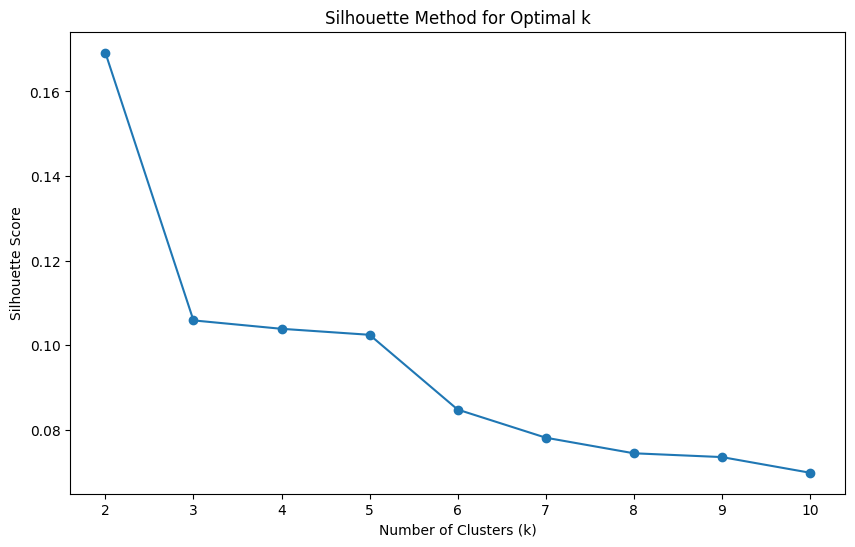

Optimal number of clusters based on Silhouette Score: 2


In [44]:
data = images_reduced
cluster_labels = train_df['label'].values
# Calculate silhouette scores for different values of k
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(data)
    silhouette_avg = silhouette_score(data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Method graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.show()

# Print the optimal number of clusters
optimal_k = k_values[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on Silhouette Score: {optimal_k}")

  These results suggests that the data naturally forms 2 distinct clusters more clearly than 7. It indicates the presence of two dominant clusters with high cohesion and separation. It means also, that The seven known classes might overlap significantly, making it challenging for the K-means algorithm to differentiate them as separate clusters. Le'ts try again, but this time with k = 2.

In [45]:
# Apply K-means clustering
k = 2
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(images_reduced)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


28657
1: defaultdict(<class 'int'>, {0: 2046, 1: 192, 2: 1622, 3: 3589, 4: 2808, 5: 845, 6: 2697})
0: defaultdict(<class 'int'>, {0: 1935, 1: 243, 2: 2469, 3: 3618, 4: 2015, 5: 2319, 6: 2259})
For cluster emotion-dict 1, the most common emotion is happy
For cluster emotion-dict 0, the most common emotion is happy


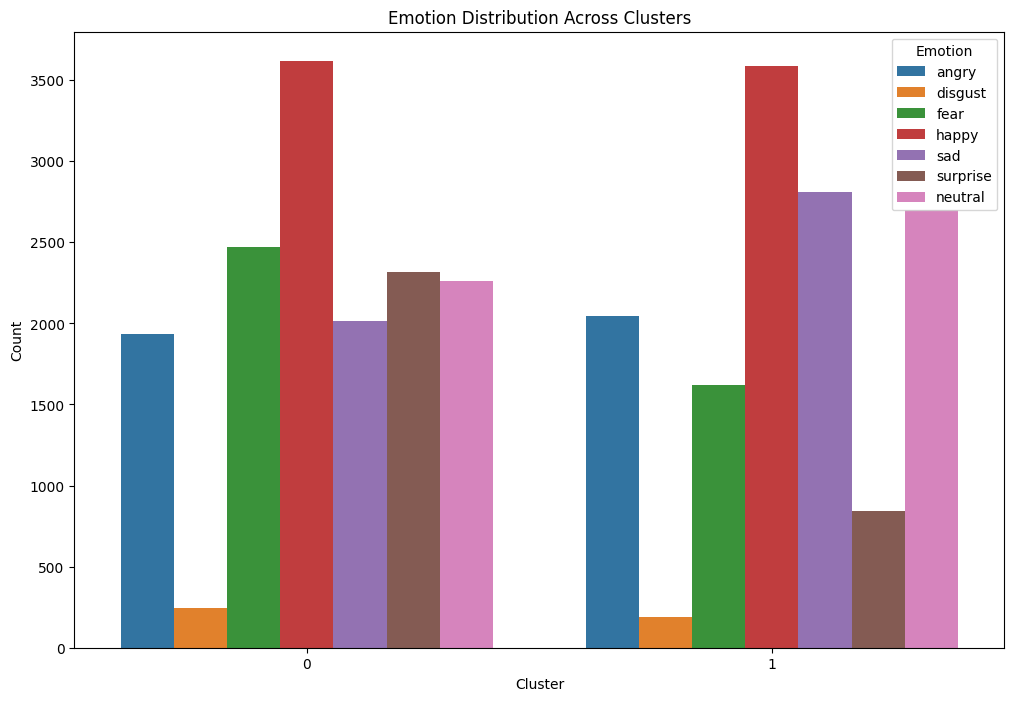

In [46]:
plot_clustering_results(clusters)

However, even with k=2, the clustering results were still unsatisfactory, showing no clear separation between the clusters and failing to group the data meaningfully by the expected emotions. This suggests that another approach might be needed, such as using extracted features instead of the original data.

Let's attempt clustering using the extracted features.

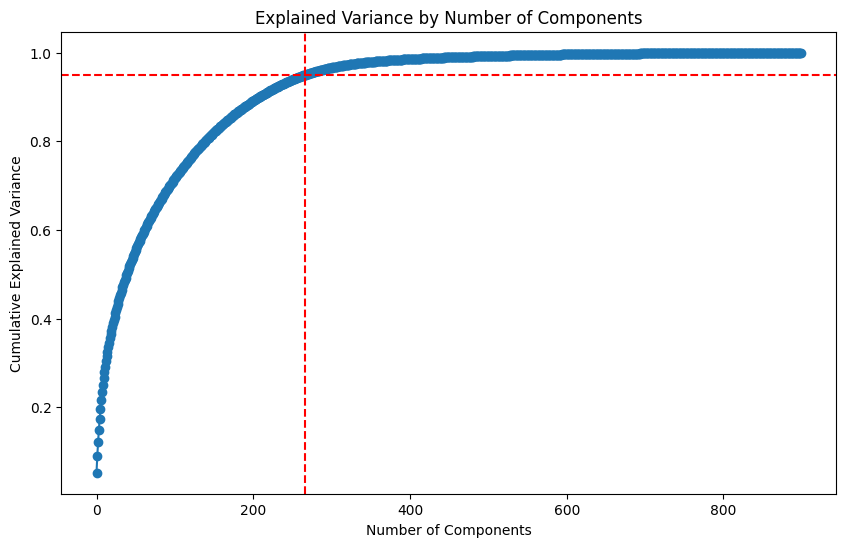

Number of components to retain 95% variance: 267


In [47]:
# Apply PCA
train_features = extract_hog_features(train_images)
pca_hog_features = PCA().fit(train_features)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_hog_features.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.axvline(x=np.argmax(np.cumsum(pca_hog_features.explained_variance_ratio_) >= 0.95), color='r', linestyle='--')
plt.show()

# Print the number of components to retain 95% variance
n_components = np.argmax(np.cumsum(pca_hog_features.explained_variance_ratio_) >= 0.95) + 1
print(f"Number of components to retain 95% variance: {n_components}")

As we can see, retaining 269 components captures 95% of the hog extracted features variance. This indicates that by keeping these 269 principal components, we preserve the majority of the essential information in the dataset while effectively reducing its dimensionality.

In [48]:
# train features are already normalized. so, we can skip this stage.

pca_269 = PCA(n_components=269)  # pca_273 - because we keep 95% of explained variance.
hog_features_reduced = pca_269.fit_transform(train_features)
# image reduced keep the new image list after dimention reduction using pca

# Apply K-means clustering
k = 7  # Suppose 7 clusters one for each emotion.
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(hog_features_reduced )

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


28657
5: defaultdict(<class 'int'>, {0: 768, 1: 128, 2: 655, 3: 1036, 4: 809, 5: 434, 6: 788})
0: defaultdict(<class 'int'>, {0: 867, 1: 39, 2: 858, 3: 1321, 4: 1392, 5: 318, 6: 905})
3: defaultdict(<class 'int'>, {0: 501, 1: 78, 2: 417, 3: 1179, 4: 550, 5: 350, 6: 689})
6: defaultdict(<class 'int'>, {0: 428, 1: 35, 2: 445, 3: 654, 4: 489, 5: 321, 6: 492})
4: defaultdict(<class 'int'>, {0: 458, 1: 19, 2: 508, 3: 950, 4: 526, 5: 378, 6: 557})
1: defaultdict(<class 'int'>, {0: 526, 1: 93, 2: 816, 3: 1055, 4: 519, 5: 1068, 6: 909})
2: defaultdict(<class 'int'>, {0: 433, 1: 43, 2: 392, 3: 1012, 4: 538, 5: 295, 6: 616})
For cluster emotion-dict 5, the most common emotion is happy
For cluster emotion-dict 0, the most common emotion is sad
For cluster emotion-dict 3, the most common emotion is happy
For cluster emotion-dict 6, the most common emotion is happy
For cluster emotion-dict 4, the most common emotion is happy
For cluster emotion-dict 1, the most common emotion is surprise
For cluste

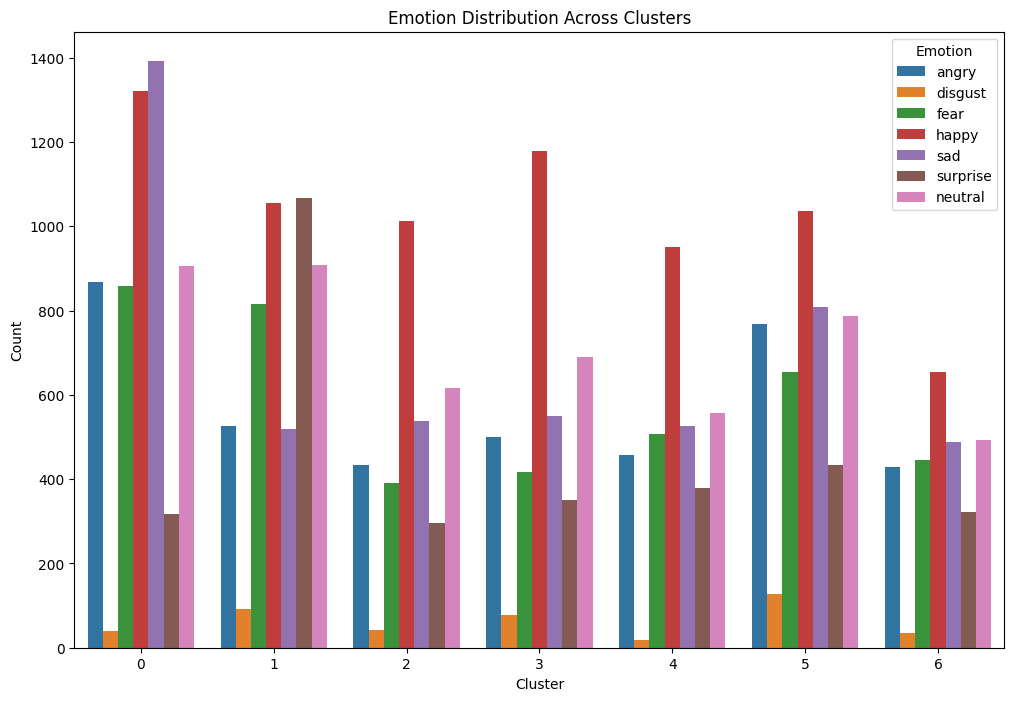

In [49]:
plot_clustering_results(clusters)

The results improved slightly. We can see that the majority in the third cluster now represents the surprise emotion.

Let's continue improving by selecting the optimal k again, this time based on the HOG-extracted features.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

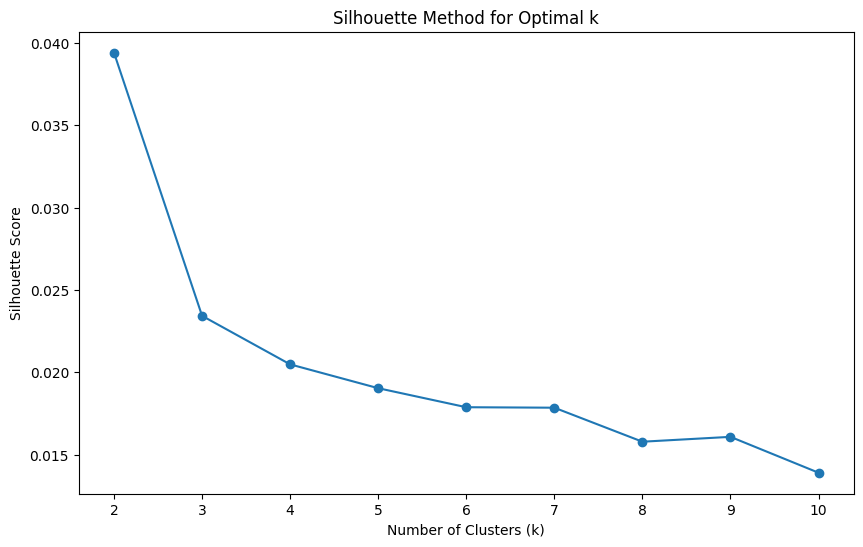

Optimal number of clusters based on Silhouette Score: 2


In [50]:
data = hog_features_reduced
cluster_labels = train_df['label'].values
# Calculate silhouette scores for different values of k
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(data)
    silhouette_avg = silhouette_score(data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Method graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.show()

# Print the optimal number of clusters
optimal_k = k_values[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on Silhouette Score: {optimal_k}")

As we can see, the optimal k is still 2, which means that the data naturally clusters into two groups more effectively than any other number of clusters. However, despite this indication, the clustering results show better separation than before, but they are still not ideal.

In [51]:
k = 2  # Suppose 7 clusters one for each emotion.
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(hog_features_reduced )

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


28657
0: defaultdict(<class 'int'>, {0: 2011, 1: 118, 2: 1995, 3: 3310, 4: 2786, 5: 1128, 6: 2117})
1: defaultdict(<class 'int'>, {0: 1970, 1: 317, 2: 2096, 3: 3897, 4: 2037, 5: 2036, 6: 2839})
For cluster emotion-dict 0, the most common emotion is happy
For cluster emotion-dict 1, the most common emotion is happy


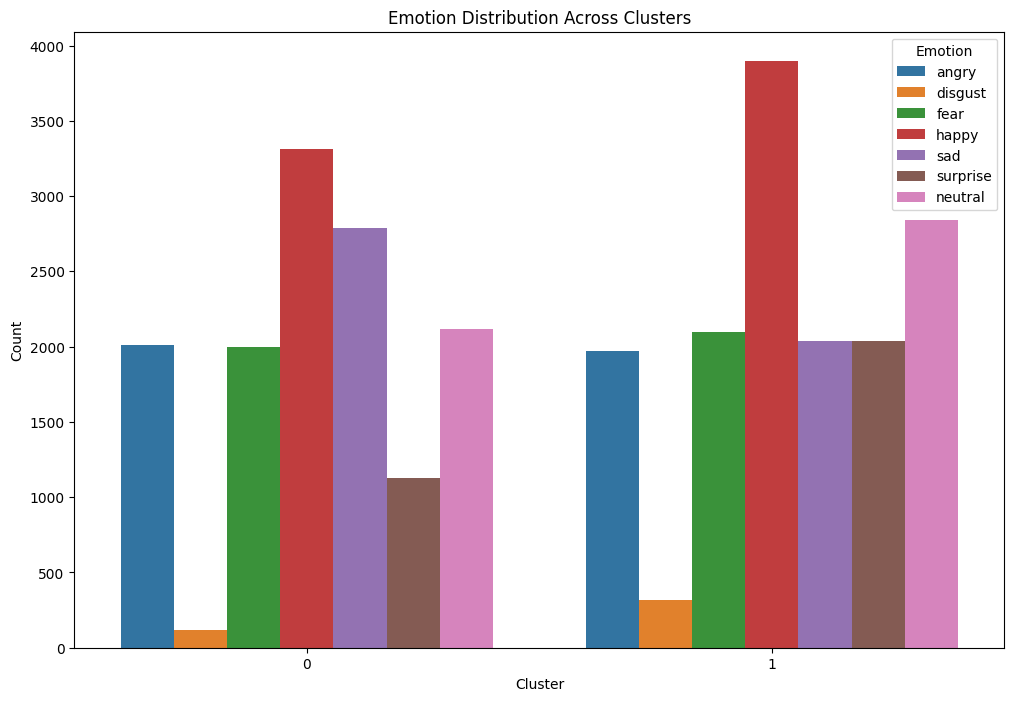

In [52]:
plot_clustering_results(clusters)

It seems that the happy emotion dominates the clusters. To address this imbalance, we will try balancing the data using SMOTE (Synthetic Minority Over-sampling Technique) before running the clustering algorithm again. By generating synthetic samples for the minority classes, SMOTE can help ensure a more equal representation of each emotion in the dataset, potentially leading to more accurate and meaningful clustering results

In [53]:
def extract_hog_features_smote(images):
    hog_features = []
    for image in images:
        fd = hog(image.reshape((48, 48)), orientations=9, pixels_per_cell=(8, 8),
                 cells_per_block=(2, 2), visualize=False, transform_sqrt=True, block_norm='L1')
        hog_features.append(fd)
    return np.array(hog_features)
train_features_smote = extract_hog_features_smote(X_resampled)

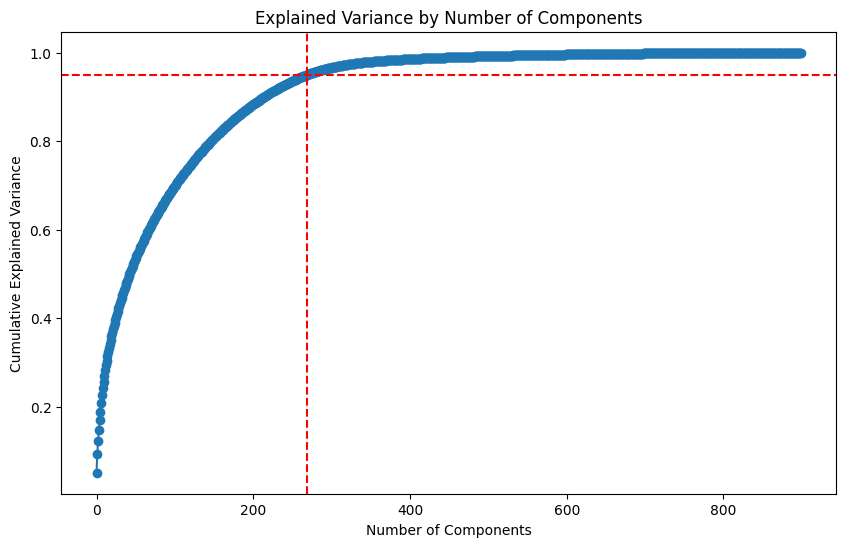

Number of components to retain 95% variance: 270


In [54]:
# Apply PCA
pca_hog_features_smote = PCA().fit(train_features_smote)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_hog_features_smote.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.axvline(x=np.argmax(np.cumsum(pca_hog_features_smote.explained_variance_ratio_) >= 0.95), color='r', linestyle='--')
plt.show()

# Print the number of components to retain 95% variance
n_components = np.argmax(np.cumsum(pca_hog_features_smote.explained_variance_ratio_) >= 0.95) + 1
print(f"Number of components to retain 95% variance: {n_components}")

In [55]:
# train features are already normalized. so, we can skip this stage.

pca_smote = PCA(n_components=271)
hog_features_reduced_smote = pca_smote.fit_transform(train_features_smote)
# image reduced keep the new image list after dimention reduction using pca

# Apply K-means clustering
k = 7  # Suppose 7 clusters one for each emotion.
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(hog_features_reduced_smote)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [56]:
label_frequencies = collections.defaultdict(lambda: collections.defaultdict(int))

label_mapping = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'sad',
    5: 'surprise',
    6: 'neutral'
}
classes = y_resampled #real labels

for data_idx, cluster in enumerate(clusters):
    label = classes[data_idx]
    label_frequencies[cluster][label] += 1
for key, value in label_frequencies.items():
  print(f"{key}: {value}")


for cluster, emotion in label_frequencies.items():
    max_emotion = max(emotion, key=emotion.get)
    print(f"For cluster emotion-dict {cluster}, the most common emotion is {label_mapping[max_emotion]}")

6: defaultdict(<class 'int'>, {0: 1123, 1: 1173, 2: 933, 3: 948, 4: 1011, 5: 714, 6: 824})
3: defaultdict(<class 'int'>, {0: 1360, 1: 291, 2: 1337, 3: 1466, 4: 1866, 5: 727, 6: 1267})
5: defaultdict(<class 'int'>, {0: 769, 1: 607, 2: 713, 3: 1214, 4: 794, 5: 579, 6: 898})
4: defaultdict(<class 'int'>, {0: 724, 1: 132, 2: 742, 3: 1075, 4: 704, 5: 695, 6: 787})
1: defaultdict(<class 'int'>, {0: 864, 1: 1140, 2: 1240, 3: 1239, 4: 737, 5: 1832, 6: 1305})
2: defaultdict(<class 'int'>, {0: 660, 1: 322, 2: 604, 3: 1259, 4: 754, 5: 533, 6: 888})
0: defaultdict(<class 'int'>, {0: 1707, 2: 1638, 3: 6, 4: 1341, 5: 2127, 6: 1238, 1: 3542})
For cluster emotion-dict 6, the most common emotion is disgust
For cluster emotion-dict 3, the most common emotion is sad
For cluster emotion-dict 5, the most common emotion is happy
For cluster emotion-dict 4, the most common emotion is happy
For cluster emotion-dict 1, the most common emotion is surprise
For cluster emotion-dict 2, the most common emotion is h

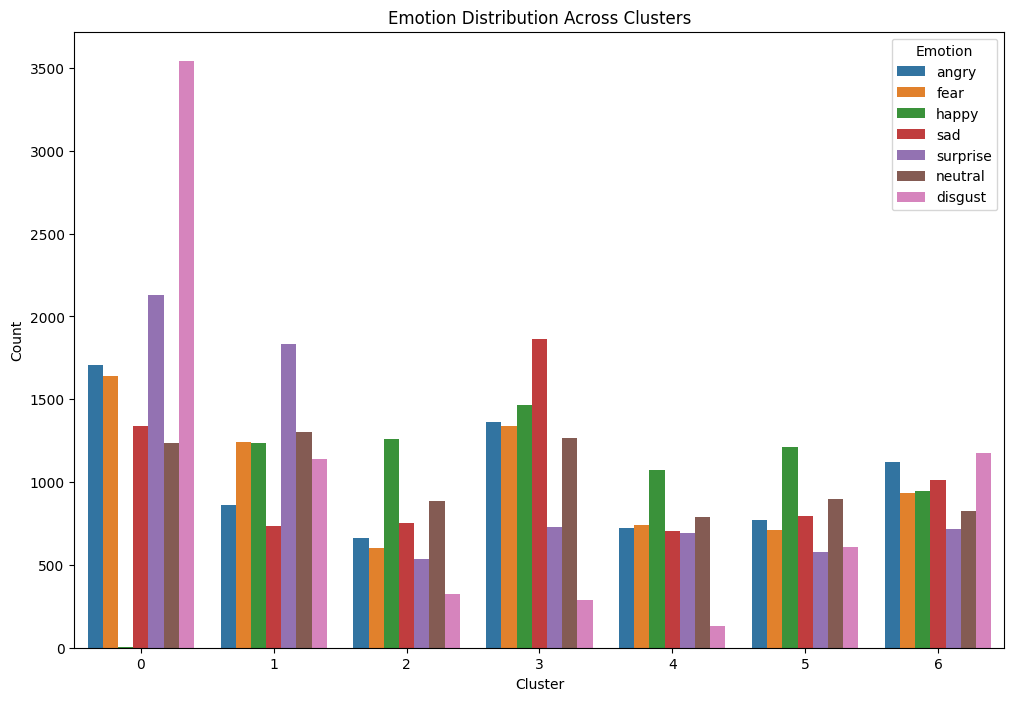

In [57]:
# Assuming label_frequencies, label_mapping, and classes are already defined as in the previous code

# Prepare data for plotting
data = []
for cluster, emotion_counts in label_frequencies.items():
    for emotion, count in emotion_counts.items():
        data.append({'Cluster': cluster, 'Emotion': label_mapping[emotion], 'Count': count})

# Convert to DataFrame
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(data=df, x='Cluster', y='Count', hue='Emotion')
plt.title('Emotion Distribution Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Emotion')
plt.show()

The clustering results have shown significant improvement. The previous poor performance was likely due to class imbalance, with an overwhelming number of instances in the 'happy' class compared to others, which hindered effective clustering.

Now, the clusters exhibit a dominant class and the separation between clusters is noticeably enhanced. This improvement indicates that balancing the data with SMOTE and re-evaluating the clustering with the optimal k has resulted in more meaningful and distinct groupings of the emotions.

Now , lets on this data choose the number of optimal k for clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

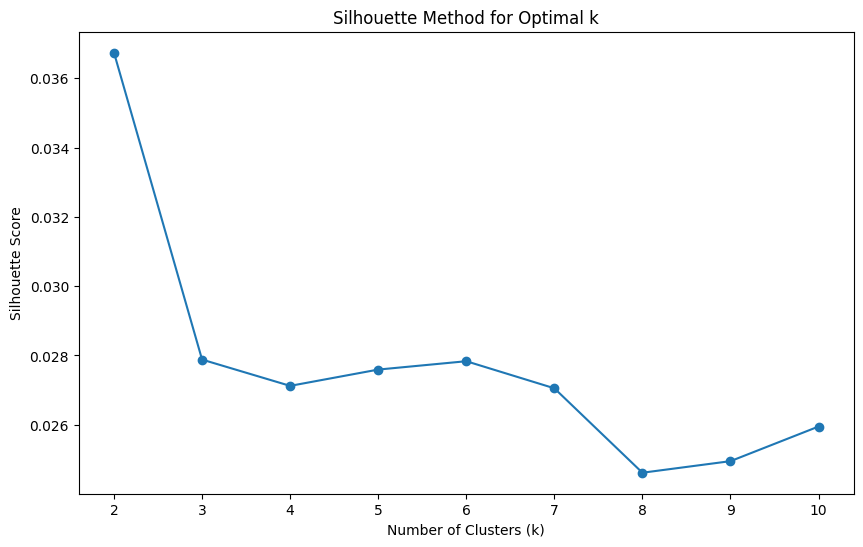

Optimal number of clusters based on Silhouette Score: 2


In [58]:
data = hog_features_reduced_smote
cluster_labels = y_resampled
# Calculate silhouette scores for different values of k
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(data)
    silhouette_avg = silhouette_score(data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Method graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.show()

# Print the optimal number of clusters
optimal_k = k_values[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on Silhouette Score: {optimal_k}")

In [59]:
# Apply K-means clustering
k = 2  # Suppose 7 clusters one for each emotion.
kmeans = KMeans(n_clusters=k)
clusters = kmeans.fit_predict(hog_features_reduced_smote)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [60]:
label_frequencies = collections.defaultdict(lambda: collections.defaultdict(int))

label_mapping = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'sad',
    5: 'surprise',
    6: 'neutral'
}
classes = y_resampled #real labels

for data_idx, cluster in enumerate(clusters):
    label = classes[data_idx]
    label_frequencies[cluster][label] += 1
for key, value in label_frequencies.items():
  print(f"{key}: {value}")


for cluster, emotion in label_frequencies.items():
    max_emotion = max(emotion, key=emotion.get)
    print(f"For cluster emotion-dict {cluster}, the most common emotion is {label_mapping[max_emotion]}")

1: defaultdict(<class 'int'>, {0: 2873, 1: 2323, 2: 3153, 3: 4761, 4: 2695, 5: 3578, 6: 3847})
0: defaultdict(<class 'int'>, {0: 4334, 1: 4884, 2: 4054, 3: 2446, 4: 4512, 5: 3629, 6: 3360})
For cluster emotion-dict 1, the most common emotion is happy
For cluster emotion-dict 0, the most common emotion is disgust


Performing clustering on the extracted features proved to be much more effective than clustering on the original images. Initially, the clustering was hindered by a class imbalance, with the 'happy' class having significantly more instances than any other class, resulting in clusters where 'happy' was the dominant class.

However, after applying SMOTE to balance the extracted features, the clustering results improved significantly. The strong emotions—happy, disgust, surprise, and sad—now dominate certain clusters, indicating that these emotions can be relatively easily classified together. On the other hand, emotions like fear are not as predominant in any cluster. This makes sense, as fear is often ambiguous and can be challenging for even humans to classify into a specific category.

The Silhouette score consistently suggested a low number of clusters, indicating minimal differences in the clustering. To account for this, we tested with 7 clusters, corresponding to the number of emotions.

Additionally, other algorithms, such as DBSCAN, were attempted to improve the clustering results. However, these algorithms did not yield satisfactory outcomes and were therefore not included in the final analysis.



---
In this section, we will use the MTCNN (Multi-task Cascaded Convolutional Networks) model for detecting faces and localizing facial landmarks in images. MTCNN is a deep learning-based framework that excels in face detection and landmark localization due to its cascaded structure of convolutional neural networks. MTCNN returns the following five key facial landmarks for each detected face, represented as (x, y) coordinates:
1. Left Eye: Center of the left eye.
2. Right Eye: Center of the right eye.
3. Nose: Tip of the nose.
4. Left Mouth Corner: Left corner of the mouth.
5. Right Mouth Corner: Right corner of the mouth.


* **Importance of Landmark Detection for Face Alignment in our Dataset**

Landmark detection refers to the identification of key points on a face, such as the corners of the eyes, nose and mouth corners.
Aligning faces based on these landmarks is crucial for standardizing facial orientations and positions, thereby enhancing the accuracy of emotion recognition.

In [61]:
def detect_landmarks(image):
    # Create MTCNN detector
    detector = MTCNN()

    # Convert grayscale image to RGB by stacking along the third axis
    image_rgb = np.stack((image,) * 3, axis=-1).astype(np.uint8)

    # Detect faces in the image
    faces = detector.detect_faces(image_rgb)

    if len(faces) == 1:
        face = faces[0]['box']  # Extract the bounding box of the face
        landmarks_points = []

        # Assuming MTCNN detects landmarks as well
        landmarks = faces[0]['keypoints']

        # Extract facial landmarks
        for key, value in landmarks.items():
            landmarks_points.append(value)

        return np.array(landmarks_points, dtype=int)

    elif len(faces) == 0:
        print("No faces detected")

    else:
        print("Multiple faces detected, unable to process")

    return None


---


Now we will implement align_face function!

In [62]:
# Function to align a face represented by a vector
def align_face(image_vector, width, height):

    image_array = np.reshape(image_vector, (height, width))

    # Detect facial landmarks
    landmarks = detect_landmarks(image_array)

    if landmarks is None:
        print("No face detected")
        return image_vector

    # Extract facial landmarks
    left_eye = landmarks[0]
    right_eye = landmarks[1]
    nose = landmarks[2]
    mouth_left = landmarks[3]
    mouth_right = landmarks[4]

    # Calculate angle between eyes
    angle = np.arctan2(right_eye[1] - left_eye[1], right_eye[0] - left_eye[0]) * 180 / np.pi

    # Calculate the midpoint between the eyes
    eye_midpoint = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)

    # Calculate the midpoint between the mouth edges
    mouth_midpoint = ((mouth_left[0] + mouth_right[0]) // 2, (mouth_left[1] + mouth_right[1]) // 2)

    # Calculate the distance between the eyes
    eye_distance = np.sqrt((right_eye[0] - left_eye[0]) ** 2 + (right_eye[1] - left_eye[1]) ** 2)

    # Define the desired eye distance in the aligned face
    desired_eye_distance = 0.4 * width

    # Calculate scale factor
    scale = desired_eye_distance / eye_distance

    # Calculate translation to center the face
    translate_x = width // 2 - eye_midpoint[0]
    translate_y = height // 2 - (eye_midpoint[1] + mouth_midpoint[1]) // 2

    # Apply transformations to align face
    aligned_face = rotate(image_array, angle)
    aligned_face = shift(aligned_face, (translate_y, translate_x))
    aligned_face = resize(aligned_face, (height, width))

    return np.reshape(aligned_face, -1)

Let's visualize the images returned by the detect_marks_landmarks function on several images in our dataset to validate the algorithm's succes

1/1 [==============================] - 0s 207ms/step
No faces detected
1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step
No faces detected
1/1 [==============================] - 0s 186ms/step
No faces detected
1/1 [==============================] - 0s 260ms/step


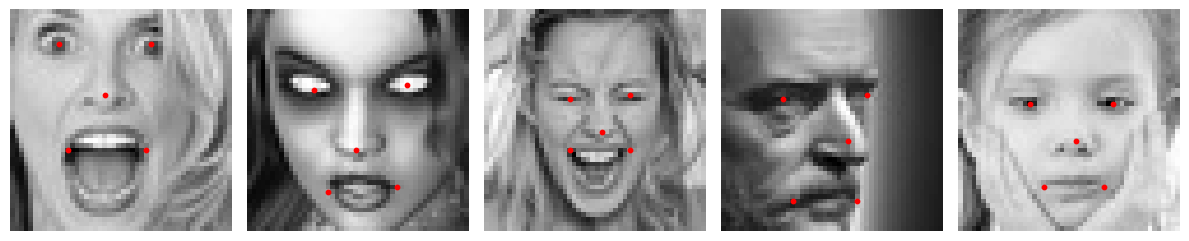

In [63]:
def show_image(image_vector, landmarks=None):
    image = image_vector.reshape(48, 48)
    plt.imshow(image, cmap='gray')
    if landmarks:
        for (x, y) in landmarks:
            plt.scatter(x, y, c='red', s=10)
    plt.axis('off')

def display_images_with_landmarks_in_grid(df, pixel_columns, rows=1, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 3))

    found_images = 0
    i = 0

    while found_images < rows * cols and i < len(df):
        image_vector = df.iloc[i][pixel_columns].values
        aligned_landmarks = detect_landmarks(np.reshape(image_vector, (48, 48)))

        if aligned_landmarks is not None:
            ax = axes[found_images]
            ax.imshow(np.reshape(image_vector, (48, 48)), cmap='gray')
            for (x, y) in aligned_landmarks:
                ax.scatter(x, y, c='red', s=10)
            ax.axis('off')
            found_images += 1

        i += 1

    plt.tight_layout()
    plt.show()

display_images_with_landmarks_in_grid(preprocess_train_df, pixel_columns, rows=1, cols=5)

**Amazing !**
The success of the algorithm in scoring the areas within the face images, including the eyes, nose, and mouth, is evident from the analysis. Notably, the algorithm demonstrated its efficacy even in identifying these areas in "half faces," where facial features are partially obscured or moved from their typical positions.

For instance, upon examining the fourth sample provided, it becomes apparent that the algorithm accurately pinpointed the relevant areas despite the partial visibility of the facial features. This capability underscores the robustness and adaptability of the algorithm in handling variations in facial orientation and expression.

The align_face function aims to align the detected face within the image vector. By detecting facial landmarks , the function calculates the necessary transformations to align the face properly. This includes determining the angle of rotation needed to orient the face correctly and calculating the translation required to center the face within the image vector. Additionally, the function resizes the face to ensure a consistent eye distance.

-----------------------------------------------------------------------
Let's take a moment to review a selection of images post face alignment, offering insight into the quality of our model and the efficacy of our face alignment efforts. This serves as a valuable gauge of our success in this task.

1/1 [==============================] - 0s 112ms/step
No faces detected
No face detected
1/1 [==============================] - 0s 19ms/step
No faces detected
No face detected
1/1 [==============================] - 0s 114ms/step
No faces detected
No face detected
1/1 [==============================] - 0s 130ms/step


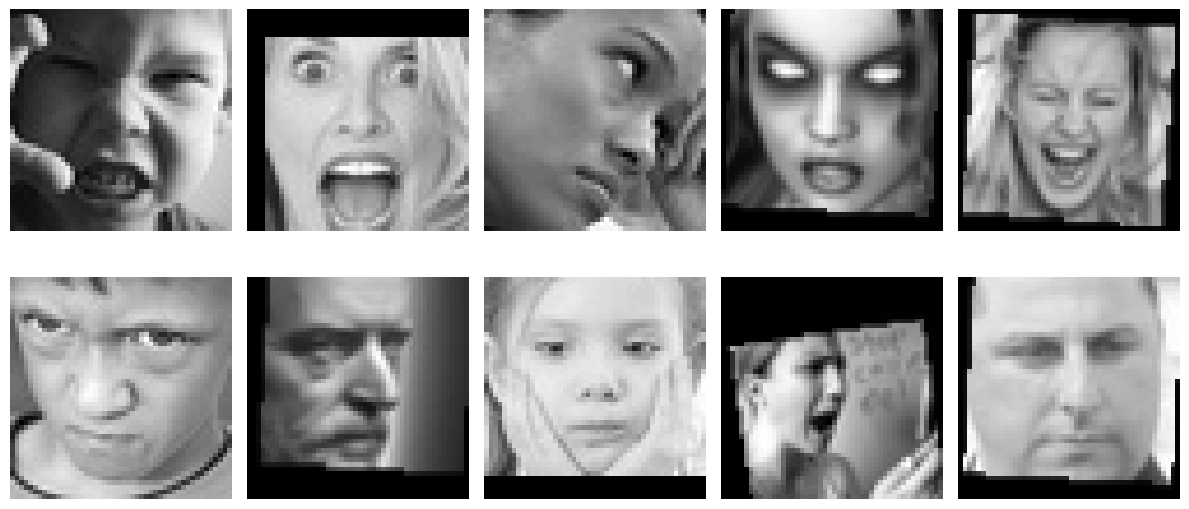

In [64]:
def display_images_in_grid(df, pixel_columns, rows=2, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 6))

    for i in range(rows * cols):
        image_vector = df.iloc[i][pixel_columns].values
        aligned_face = align_face(image_vector, 48, 48)
        image = aligned_face.reshape(48, 48)

        ax = axes[i // cols, i % cols]
        ax.imshow(image, cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

pixel_columns = [f"pixel_{i}" for i in range(48*48)]
display_images_in_grid(preprocess_train_df, pixel_columns, rows=2, cols=5)


Our visual analysis indicates that the algorithm was unable to achieve success in the facial alignment task. This task is complex, and currently, there is no readily available model that can be directly utilized for this purpose.
in the other hand the algorithm effectively placed the eyes of each face at consistent coordinates within the images, demonstrating precise pixel positioning.

Moving forward, our approach will involve constructing models using datasets both with and without face alignment. We anticipate comparable outcomes between the two, as the fundamental change brought about by alignment appears minimal. However, we lean towards the notion that utilizing data post-alignment may yield better results. The consistent pixel placement of the eyes across a significant portion of images simplifies the task for the network, enhancing its ability to discern facial expressions effectively.







# **Classification**

In [65]:
#import relevant libraries
import keras
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
import tensorflow as tf
from skimage.color import gray2rgb
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import f1_score
from keras.utils import plot_model
from joblib import Parallel, delayed
from collections import Counter
!pip install pydot
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import pydot
from sklearn import svm
from skimage.feature import hog
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc, RocCurveDisplay


We will evaluate the models using three main metrics:

1. Accuracy
2. Confusion Matrix
3. ROC & AUC (Receiver Operating Characteristic & Area Under the Curve)

# Naive Bayes Classification on HOG  Features Without SMOTE

We will start by examining the data using a relatively simple model, the Naive Bayes classifier. This initial step will involve a thorough examination of the dataset to understand its structure, characteristics, and any underlying patterns. By using the Naive Bayes model, which is a probabilistic classifier based on Bayes' theorem, we can make predictions by assuming that the features are conditionally independent given the class label. This assumption, while sometimes simplistic, often provides surprisingly good results

In [66]:
image_paths = train_df['image_path'].values
X1 = load_and_preprocess_images(image_paths)

In [67]:
y1 = train_df['label'].values

 To enhance the performance of our classifier, we will use Histogram of Oriented Gradients (HOG) features, which are effective in capturing the edge and gradient structure of images , Using HOG features not only enhances the performance of the classifier by capturing essential facial characteristics but also significantly reduces the computational cost. When we initially tried running the algorithm without HOG, the training and prediction times were substantially longer due to the higher dimensionality of raw pixel data

In [68]:
def extract_hog_features(images):
    hog_features = []
    for image in images:
        fd = hog(image.reshape((48, 48)), orientations=9, pixels_per_cell=(8, 8),
                 cells_per_block=(2, 2), visualize=False, transform_sqrt=True, block_norm='L1')
        hog_features.append(fd)
    return np.array(hog_features)

In [69]:
hog_features1 = extract_hog_features(X1)  # X1 = load_and_preprocess_images(image_paths)

In [70]:
def preprocess_test_data2(df):
    images_array = []
    labels = df['label'].values
    num_classes = 7

    labels_one_hot = np.eye(num_classes)[labels]

    for image_path in df['image_path']:
        image = cv2.imread(image_path)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray_image = gray_image.astype('float32') / 255.0
        images_array.append(gray_image)

    return np.array(images_array), labels_one_hot

In [71]:
X1_test , y1_test= preprocess_test_data2(test_df)
X1_test_hog = extract_hog_features(X1_test)

Now, it's time to train our classifier and make predictions on the validation set.

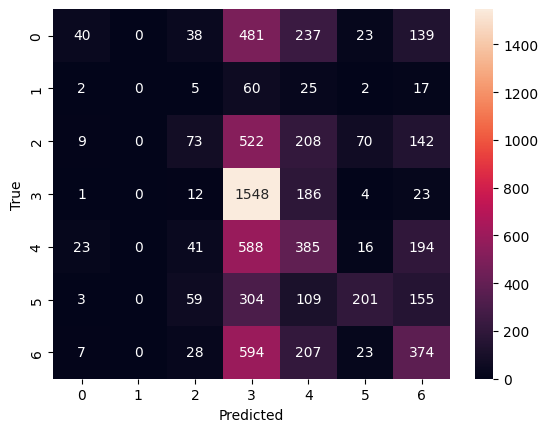

Accuracy: 0.3651434940094734


In [72]:
clf = MultinomialNB()
clf.fit(hog_features1, y1) # training the model on hog features
y1_pred = clf.predict(X1_test_hog)# predicting on the test set
cm = confusion_matrix(y1_test.argmax(axis=1), y1_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_df['label'].unique(), yticklabels=test_df['label'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print(f'Accuracy: {accuracy_score(y1_test.argmax(axis=1), y1_pred)}')


From the confusion matrix, it is evident that the fourth column is lighter in color and contains larger values compared to the other columns. This observation suggests that the model predominantly classifies samples into class 4, which corresponds to the "happy" emotion.



---




Let's evaluate the model using another measure called the Receiver Operating Characteristic (ROC). The ROC curves provide a comprehensive way to evaluate the performance of our multi-class classification model. Each curve represents the trade-off between the True Positive Rate (TPR) and the False Positive Rate (FPR) for different threshold settings. The Area Under the Curve (AUC) is a summary measure that provides insight into the model's overall ability to discriminate between classes.







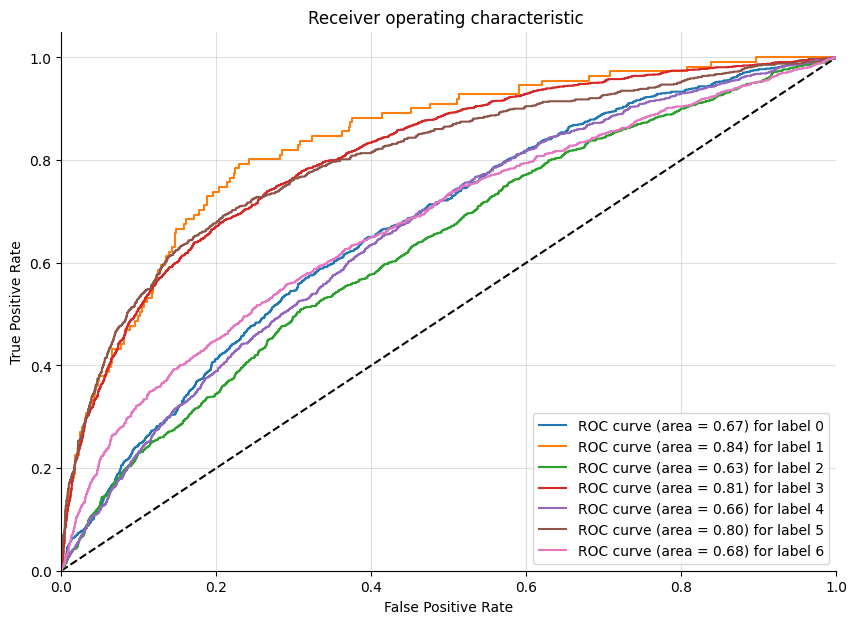

Average AUC: 0.73


In [73]:
y_prob = clf.predict_proba(X1_test_hog)

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 7
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y1_test[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic ')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for label {i}')
ax.legend(loc="best")
ax.grid(alpha=0.4)
sns.despine()
plt.show()

avg_auc = np.mean([roc_auc[i] for i in range(n_classes)])
print(f'Average AUC: {avg_auc:.2f}')

Label 0 (Angry): The ROC curve for label 0 has an AUC of 0.67, indicating moderate discriminative ability

Label 1 (Disgust): The ROC curve for label 1 has an AUC of 0.84, showing the best performance among all classes.

Label 2 (Fear): The ROC curve for label 2 has an AUC of 0.63, indicating the model struggles with this class.

Label 3 (Happy): The ROC curve for label 3 has an AUC of 0.81, indicating good performance.

Label 4 (Sad): The ROC curve for label 4 has an AUC of 0.66, showing moderate performance.

Label 5 (Surprise): The ROC curve for label 5 has an AUC of 0.80, indicating good performance.

Label 6 (Neutral): The ROC curve for label 6 has an AUC of 0.68, indicating moderate performance.

The average AUC across all classes is 0.73, indicating that the model has a reasonably good ability to distinguish between different emotions overall.
The performance varies significantly across different classes, suggesting that the model is more effective at predicting certain emotions (e.g., Disgust, Happy, Surprise) than others (e.g., Fear, Sad).

**Note that the ROC curve for label 2 (Fear) exhibits the lowest performance among all classes, with an AUC of 0.63.**

---



# Naive Bayes Classification on VGG Extracted Features Without SMOTE


In [74]:
test_images = load_and_preprocess_images(test_df['image_path'])
model = models.vgg16(pretrained=True)
model.eval()

# Preprocess function for VGG16
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_images_reshaped = test_images.reshape(-1, 48, 48)

images_rgb = [cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) for img in test_images_reshaped]

test_features2, processed_test_images2 = extract_features_vgg(images_rgb, model)




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [75]:
train_features2_reshaped = np.reshape(train_features2, (train_features2.shape[0], -1))
test_features2_reshaped = np.reshape(test_features2, (test_features2.shape[0], -1))

clf = MultinomialNB()
clf.fit(train_features2_reshaped, y1)
y4_pred = clf.predict(test_features2_reshaped )

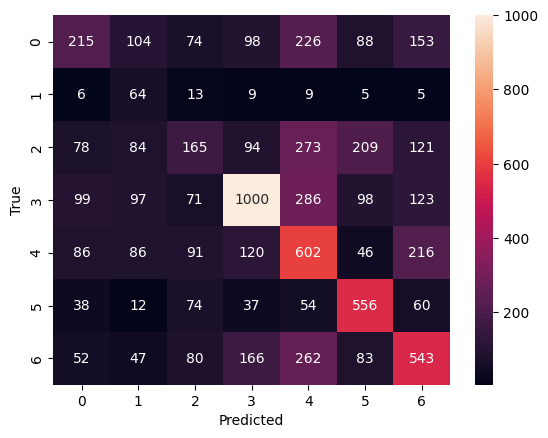

Accuracy: 0.4381443298969072


In [76]:
cm = confusion_matrix(y1_test.argmax(axis=1), y4_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_df['label'].unique(), yticklabels=test_df['label'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print(f'Accuracy: {accuracy_score(y1_test.argmax(axis=1), y4_pred)}')

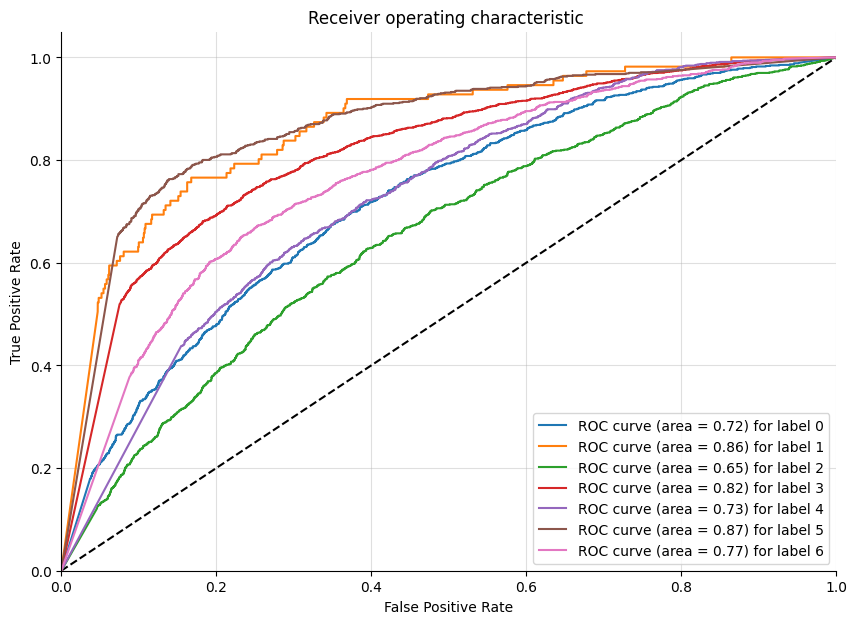

Average AUC: 0.77


In [77]:
y_prob = clf.predict_proba(test_features2_reshaped)

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 7
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y1_test[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic ')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for label {i}')
ax.legend(loc="best")
ax.grid(alpha=0.4)
sns.despine()
plt.show()

avg_auc = np.mean([roc_auc[i] for i in range(n_classes)])
print(f'Average AUC: {avg_auc:.2f}')


In this comparison of Naive Bayes classification on HOG and VGG extracted features, the results show that VGG features provide superior performance. As we saw in the EDA section, HOG features are focused on the eyes region, while VGG features encompass both the eyes and mouth regions. The accuracy of the Naive Bayes classifier using HOG features was 0.3651 with an average AUC of 0.73. In contrast, the classifier using VGG extracted features achieved an accuracy of 0.4381 and an average AUC of 0.77. These results suggest that VGG features, derived from a deep convolutional neural network, capture more comprehensive and discriminative information compared to the simpler HOG features. The richer feature representation from VGG allows the Naive Bayes classifier to make better predictions, resulting in improved classification accuracy and AUC.

#  Naive Bayes Classification on HOG Features with SMOTE


Notably, in the dataset we analyzed (without data balancing), class 4 appears most frequently, as highlighted in the Exploratory Data Analysis (EDA) section. This imbalance in the dataset has likely skewed the model's predictions, leading to a bias towards the "happy" emotion.

To address this issue, we will apply the Synthetic Minority Over-sampling Technique (SMOTE) to balance the dataset. By generating synthetic samples for the underrepresented classes, SMOTE helps in creating a more balanced dataset, which should improve the model's performance and lead to more accurate classification results. We will then re-run the model on the balanced dataset and evaluate the results to see if there is an improvement in the classification accuracy across all classes.


Let's train a Multinomial Naive Bayes classifier on the FER2013 dataset after applying SMOTE on it .

In [78]:
X = preprocess_train_df.drop('label', axis=1).values
y = preprocess_train_df['label'].values

In [79]:
hog_features = extract_hog_features(X)


In [80]:
X_test , y_test= preprocess_test_data2(test_df)
X_test_hog = extract_hog_features(X_test)

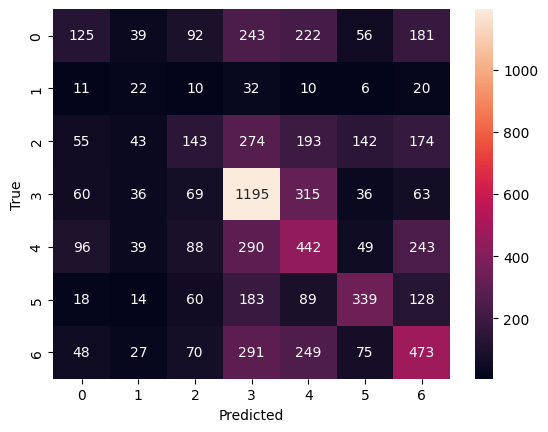

Accuracy: 0.3815826135413764


In [81]:
clf = MultinomialNB()
clf.fit(hog_features, y)
y_pred = clf.predict(X_test_hog)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_df['label'].unique(), yticklabels=test_df['label'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print(f'Accuracy: {accuracy_score(y_test.argmax(axis=1), y_pred)}')



From the confusion matrices, we can see the impact of applying the SMOTE method on the dataset. Before applying SMOTE, the fourth column, corresponding to the "happy" emotion, is noticeably lighter in color and contains larger values compared to other columns. This indicates that the model is biased towards predicting the "happy" emotion, likely due to the imbalance in the dataset where class 4 appears most frequently. The overall accuracy of the model is 36.51%. After applying SMOTE, the distribution of predictions across all classes is more balanced, as indicated by the more even color distribution in the confusion matrix. There is a noticeable improvement in the classification accuracy for previously underrepresented classes. The overall accuracy of the model improves to 38.14%, demonstrating the positive impact of balancing the dataset with SMOTE. Applying SMOTE to balance the dataset has led to a more evenly distributed classification across all classes and improved the overall accuracy of the model. This highlights the importance of addressing class imbalance in datasets to ensure that the model does not become biased towards more frequent classes.


---



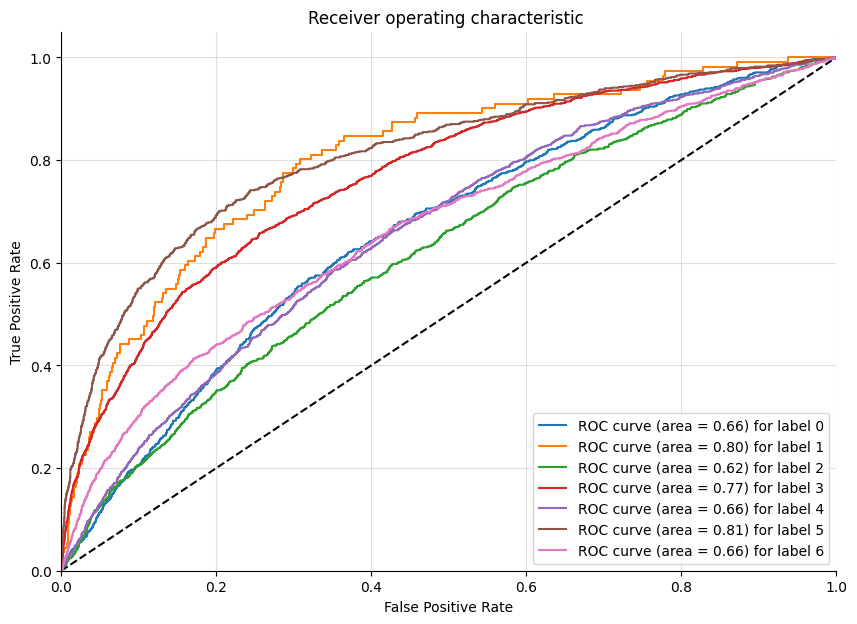

Average AUC: 0.71


In [82]:
y_prob = clf.predict_proba(X_test_hog)

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 7
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic ')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for label {i}')
ax.legend(loc="best")
ax.grid(alpha=0.4)
sns.despine()
plt.show()

avg_auc = np.mean([roc_auc[i] for i in range(n_classes)])
print(f'Average AUC: {avg_auc:.2f}')

According to the ROC index and the AUC values, there is no significant improvement observed after applying SMOTE. The average AUC slightly decreased from 0.73 to 0.71, indicating a marginal decline in the model's overall discriminative ability. Individual class AUCs also showed minor changes, with some classes experiencing a slight improvement and others a slight decline.

While the ROC index and AUC values do not show a significant improvement after applying SMOTE, the confusion matrix and accuracy metrics indicate a positive impact. The overall accuracy has increased, and the reduced gap between classes demonstrates better balance and consistency in the model's performance. Thus, applying SMOTE has contributed to an improvement in the model's ability to handle class imbalance, even though this is not fully captured by the AUC values.

**also after applying SMOTE, label 2 - Fear continues to show the worst performance, indicating persistent difficulty in classification, with an AUC of 0.62.**




---


After training the Multinomial Naive Bayes model, we achieved an accuracy of 38.23% on the validation set. However, we aim to further improve the accuracy of our classifier. To achieve this, we will leverage two powerful techniques: Histogram of Oriented Gradients (HOG) for feature extraction and Support Vector Machine (SVM) for classification.






#  SVM Classification on HOG Features with SMOTE


SVM aims to find the optimal hyperplane that best separates the data points of different classes in a high-dimensional space. The optimal hyperplane maximizes the margin between the closest points (support vectors) of different classes ,
and HOG captures the structure or the shape of an object by counting occurrences of gradient orientation in localized portions of an image.

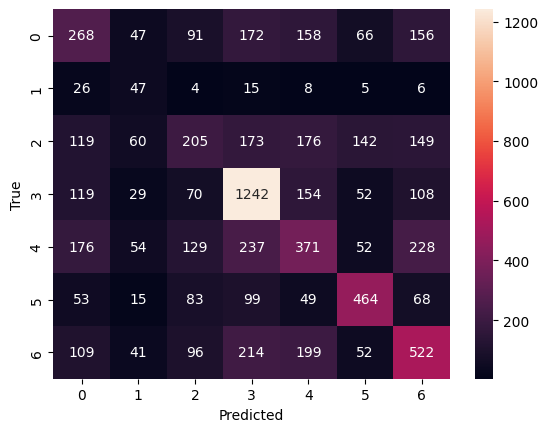

Accuracy: 0.43452215101699637


In [83]:
# Train the SVM on the HOG features
clf = svm.SVC(kernel='linear', C=1.0, probability=True)
clf.fit(hog_features, y)
y_pred = clf.predict(X_test_hog)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred)

sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_df['label'].unique(), yticklabels=test_df['label'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(f'Accuracy: {accuracy_score(y_test.argmax(axis=1), y_pred)}')



This approach improved our accuracy to 43.81%.

we can see that :

The accuracy along the main diagonal (correct predictions) has increased for most classes.

The improvement in accuracy indicates that HOG features combined with the SVM classifier have significantly enhanced our model's ability to correctly classify different emotions.

However, one exception is department 5, where the accuracy did not improve and might have even slightly decreased.


---



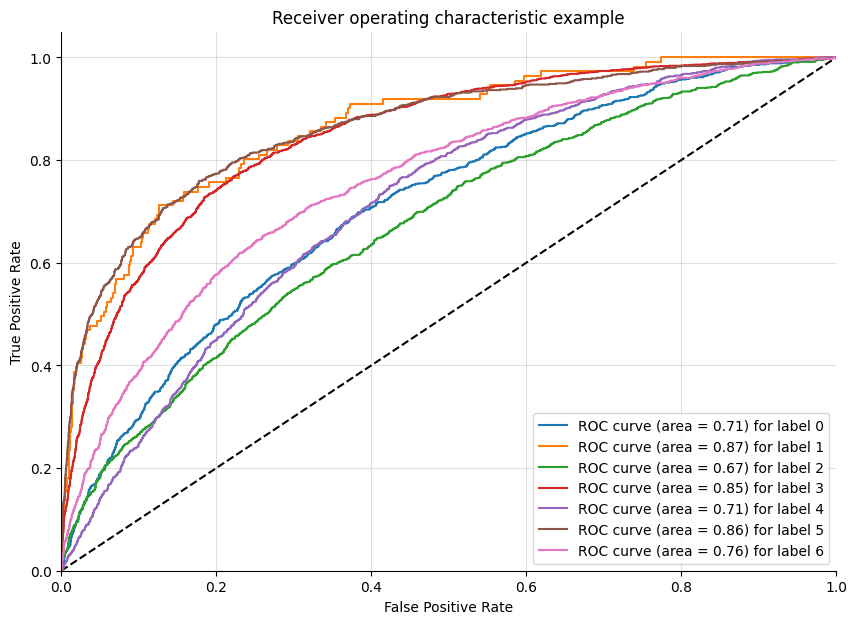

Average AUC: 0.78


In [84]:

y_prob = clf.predict_proba(X_test_hog)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 7
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for label {i}')
ax.legend(loc="best")
ax.grid(alpha=0.4)
sns.despine()
plt.show()

avg_auc = np.mean([roc_auc[i] for i in range(n_classes)])
print(f'Average AUC: {avg_auc:.2f}')


The SVM model improved AUC values for most classes compared to both the initial model and the model after SMOTE. The highest improvement was observed in 'Disgust' (from 0.84 to 0.87) and 'Happy' (from 0.81 to 0.85).
The gap between the highest and lowest AUC values narrowed after applying SVM, suggesting better class balance. This indicates that the SVM model is more consistent in predicting different emotions, addressing class imbalance more effectively.


---



# **ResNet-50 with SMOTE**

to achieve even better performance, we will now explore a more complex and powerful model: **ResNet-50**.

Before diving into model training, it's crucial to preprocess our data effectively to ensure optimal representation for the neural network. This preparation phase lays the foundation for successful training by transforming data into a format that the network can effectively learn from.


In [85]:
def preprocess_train_data(preprocess_train_df, pixel_columns,flag = False):
    # Step 1: Reshape the image vectors into 48x48 pixel images
    image_size = (48, 48)
    images = []
    for i in range(len(preprocess_train_df)):
        if flag == False :
          image_vector = preprocess_train_df.iloc[i][pixel_columns].values
        else :
          image_vector = preprocess_train_df.iloc[i]['Aligned Images']
        image_array = np.reshape(image_vector, image_size)

        images.append(image_array)

    # Step 2: Convert images to array format
    images_array = np.array(images, dtype=np.float32)
    images_array = np.expand_dims(images_array, axis=-1)  # Add channel dimension

    # Step 3: Normalization
    #images_array = images_array / 255.0

    # Step 4: Extract labels
    labels = preprocess_train_df.iloc[:, -1].values

    # Step 5: Apply one-hot encoding to labels
    encoder = OneHotEncoder(sparse=False, categories='auto')
    labels_one_hot = encoder.fit_transform(labels.reshape(-1, 1))

    return images_array, labels_one_hot


In [86]:
def preprocess_image(x):
    # Repeat the grayscale channel to simulate RGB
    rgb_image = tf.repeat(x, 3, axis=-1)
    return rgb_image

datagen = ImageDataGenerator()

In [87]:
pixel_columns = [f"pixel_{i}" for i in range(48*48)]
X_train, y_train = preprocess_train_data(preprocess_train_df, pixel_columns)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


The ResNet model receives RGB images, so we will use convert_grayscale_to_rgb to convert the images in our data to fit the model

In [88]:
def convert_grayscale_to_rgb(img):
  img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  return img_rgb

In [89]:
X_train_rgb = np.array([convert_grayscale_to_rgb(img) for img in X_train])

We chose a batch size of 32 because using a larger batch size exceeded our memory capacity.

In [90]:
BATCH_SIZE = 32
STEPS_PER_EPOCH = np.ceil(len(preprocess_train_df) / BATCH_SIZE)

In [91]:
X_train_rgb_normalized = X_train_rgb / 255.0

In [92]:

train_generator = datagen.flow(X_train_rgb_normalized, y_train, batch_size=32)

Now let's build a neural network model and utilize the ResNet50 architecture. The model consists of an input layer with an input shape of (48, 48, 3), indicating three channels for RGB images. It then utilizes a pre-trained ResNet50 model (excluding the top layer) with weights initialized from ImageNet. This is followed by a Global Average Pooling 2D layer to reduce spatial dimensions, and finally, a Dense layer with softmax activation, outputting probabilities for each of the seven categories. The model is compiled using the Adam optimizer with a categorical cross-entropy loss function and accuracy as the evaluation metric

In [93]:
def build_and_compile_model():
    NUM_CATEGORIES = 7


    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(48, 48, 3)),
        tf.keras.applications.ResNet50(include_top=False, weights="imagenet"),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(NUM_CATEGORIES, activation="softmax")
    ])

    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [94]:
model = build_and_compile_model()
model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_126 (Dense)           (None, 7)                 14343     
                                                                 
Total params: 23602055 (90.03 MB)
Trainable params: 23548935 (89.83 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [95]:
def preprocess_test_data(df, target_size=(224, 224)):
    images_array = []
    labels = df['label'].values
    num_classes = 7

    # Convert labels to one-hot encoded format
    labels_one_hot = np.eye(num_classes)[labels]

    for image_path in df['image_path']:
        image = cv2.imread(image_path)
        # Resize image to fit ResNet50 input size
        #image = cv2.resize(image, target_size)
        image = image.astype('float32') / 255.0  # Normalize pixel values

        images_array.append(image)

    return np.array(images_array), labels_one_hot

let's visualize the model architecture as a diagram

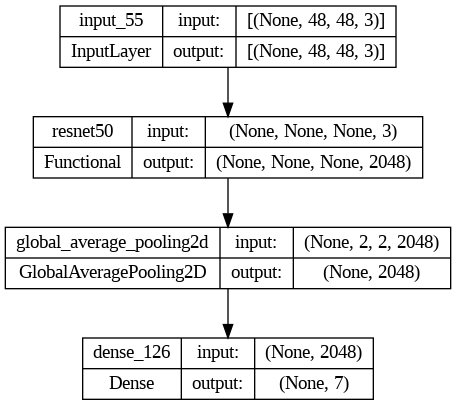

In [96]:
plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)


-The None values indicate that these dimensions can be of any size

In [97]:
test_images, test_labels = preprocess_test_data(test_df,pixel_columns)

In [98]:
test_images, test_labels = preprocess_test_data(test_df,pixel_columns)
test_generator = datagen.flow(test_images, test_labels, batch_size=32)
history = model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
1577/1577 [==============================] - 103s 45ms/step - loss: 2.1325 - accuracy: 0.1659 - val_loss: 1.9859 - val_accuracy: 0.2066
Epoch 2/10
1577/1577 [==============================] - 67s 43ms/step - loss: 1.7696 - accuracy: 0.2831 - val_loss: 1.6823 - val_accuracy: 0.3642
Epoch 3/10
1577/1577 [==============================] - 67s 43ms/step - loss: 1.4987 - accuracy: 0.4179 - val_loss: 1.4395 - val_accuracy: 0.4398
Epoch 4/10
1577/1577 [==============================] - 67s 43ms/step - loss: 1.3639 - accuracy: 0.4700 - val_loss: 1.6919 - val_accuracy: 0.4114
Epoch 5/10
1577/1577 [==============================] - 67s 43ms/step - loss: 1.2709 - accuracy: 0.5089 - val_loss: 1.6686 - val_accuracy: 0.4153
Epoch 6/10
1577/1577 [==============================] - 67s 43ms/step - loss: 1.1875 - accuracy: 0.5406 - val_loss: 2.8955 - val_accuracy: 0.3580
Epoch 7/10
1577/1577 [==============================] - 67s 43ms/step - loss: 1.1016 - accuracy: 0.5782 - val_loss: 1.3785 



---



To understand the performance of our model during training, we will plot the accuracy and loss for both the training and validation sets after each epoch. These plots will help us observe how well our model is learning and generalizing.

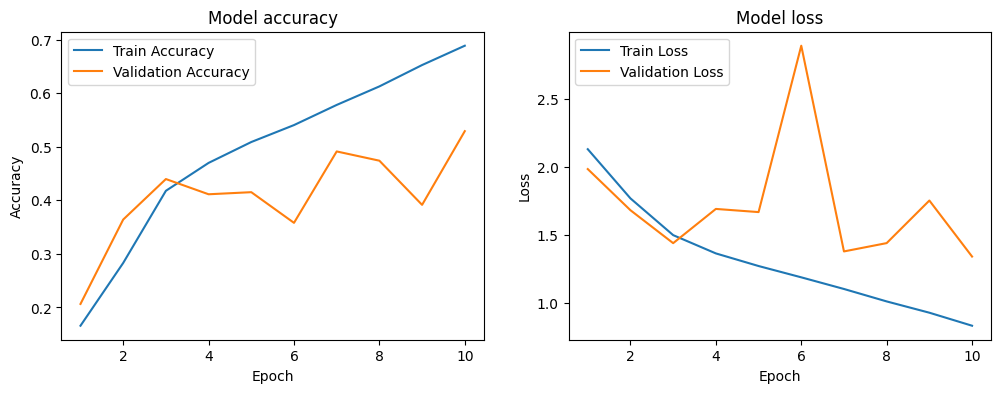

In [99]:
epochs = np.arange(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Train Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

After analyzing the training and validation accuracy and loss curves, we decided to use 6 epochs for training our model. This decision was based on the following observations:

**Maximized Accuracy:** The accuracy for both training and validation sets improves during the first 6 epochs

**Minimized Loss:** The loss for both training and validation sets decreases  during the first 6 epochs and begins to level off

**Overfitting:** By limiting the number of epochs to 6, we aim to reduce the risk of overfitting, where the model might perform well on the training data but poorly on unseen validation data.

--------------------------------------------------------------------------------
Now we will investigate the impact of fine-tuning the layers of the ResNet50 model. Initially, we will set layer.trainable = False for the ResNet50 layers, effectively freezing them, meaning that their weights will not be updated during training. We'll then observe the model's performance. Subsequently, we will set layer.trainable = True for the ResNet50 layers, allowing them to be trained along with the additional layers we've added. This process, known as fine-tuning, enables the model to adapt more specifically to our dataset. By comparing the performance before and after fine-tuning, we can assess the effectiveness of this technique in improving the model's performance

In [100]:
model = build_and_compile_model()
# Freeze the ResNet50 layers
for layer in model.layers:
    if layer.name.startswith('resnet50'):
        layer.trainable = False

history = model.fit(train_generator, epochs=6)


Epoch 1/6
1577/1577 [==============================] - 93s 41ms/step - loss: 2.0045 - accuracy: 0.2326
Epoch 2/6
1577/1577 [==============================] - 65s 41ms/step - loss: 1.5733 - accuracy: 0.3851
Epoch 3/6
1577/1577 [==============================] - 65s 41ms/step - loss: 1.4282 - accuracy: 0.4454
Epoch 4/6
1577/1577 [==============================] - 65s 41ms/step - loss: 1.3389 - accuracy: 0.4804
Epoch 5/6
1577/1577 [==============================] - 64s 41ms/step - loss: 1.2825 - accuracy: 0.5028
Epoch 6/6
1577/1577 [==============================] - 65s 41ms/step - loss: 1.1960 - accuracy: 0.5376


In [101]:

NUM_CATEGORIES = 7

model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(48, 48, 3)),
        tf.keras.applications.ResNet50(include_top=False, weights="imagenet"),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(NUM_CATEGORIES, activation="softmax")
    ])

# Unfreeze the ResNet50 layers
for layer in model.layers:
    if layer.name.startswith('resnet50'):
        layer.trainable = True

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(train_generator, epochs=6)


Epoch 1/6
1577/1577 [==============================] - 93s 41ms/step - loss: 1.4820 - accuracy: 0.4584
Epoch 2/6
1577/1577 [==============================] - 64s 41ms/step - loss: 1.1729 - accuracy: 0.5607
Epoch 3/6
1577/1577 [==============================] - 64s 41ms/step - loss: 1.0377 - accuracy: 0.6119
Epoch 4/6
1577/1577 [==============================] - 65s 41ms/step - loss: 0.9167 - accuracy: 0.6562
Epoch 5/6
1577/1577 [==============================] - 65s 41ms/step - loss: 0.7933 - accuracy: 0.7046
Epoch 6/6
1577/1577 [==============================] - 65s 41ms/step - loss: 0.6801 - accuracy: 0.7502


The training process demonstrated a clear improvement in both loss and accuracy across both phases:


*   Frozen ResNet50 Layers: Initial training focused on the newly added layers, achieving 53.35% accuracy by Epoch 6.
*   Unfrozen ResNet50 Layers: Fine-tuning the entire model resulted in further improvements, achieving 71.97% accuracy by Epoch 6.

These results highlight the importance of fine-tuning pre-trained models for specific datasets, as it significantly enhances model performance.





In [102]:
# Fit the model using the generator
#model.fit(train_generator, epochs=5)

let's evaluate our model

In [103]:
test_images, test_labels = preprocess_test_data(test_df)

In [104]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_images, test_labels)

print("Test Accuracy:", accuracy)


225/225 [==============================] - 3s 7ms/step - loss: 1.2742 - accuracy: 0.5591
Test Accuracy: 0.5590693950653076


In [105]:
def plot_confusion_matrix(model, test_images, test_labels):
    predictions = model.predict(test_images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(test_labels, axis=1)

    confusion_matrix = tf.math.confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


225/225 [==============================] - 2s 6ms/step


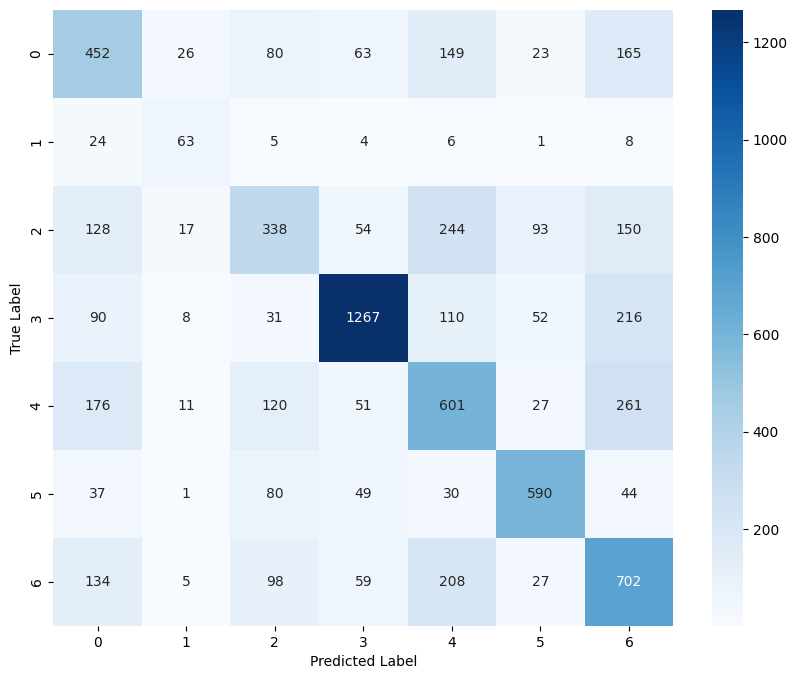

In [106]:
plot_confusion_matrix(model, test_images, test_labels)

We can see that in each row of the confusion matrix, the largest number is on the main diagonal. This means that for each category, the model most frequently classifies the images into the correct category.

In addition, we can see that for the emotion "happy," we received hight accuracy. This may be because the training dataset has the most samples belonging to the "happy" class, providing better diversity compared to the diversity we artificially created using SMOTE. Later, we will examine another method for balancing the data.

Surprisingly 😯, we got the highest accuracy (713/831 = 0.85) in the emotion "surprised."  even though it is second to last in terms of the number of samples in the original database.

225/225 [==============================] - 1s 6ms/step


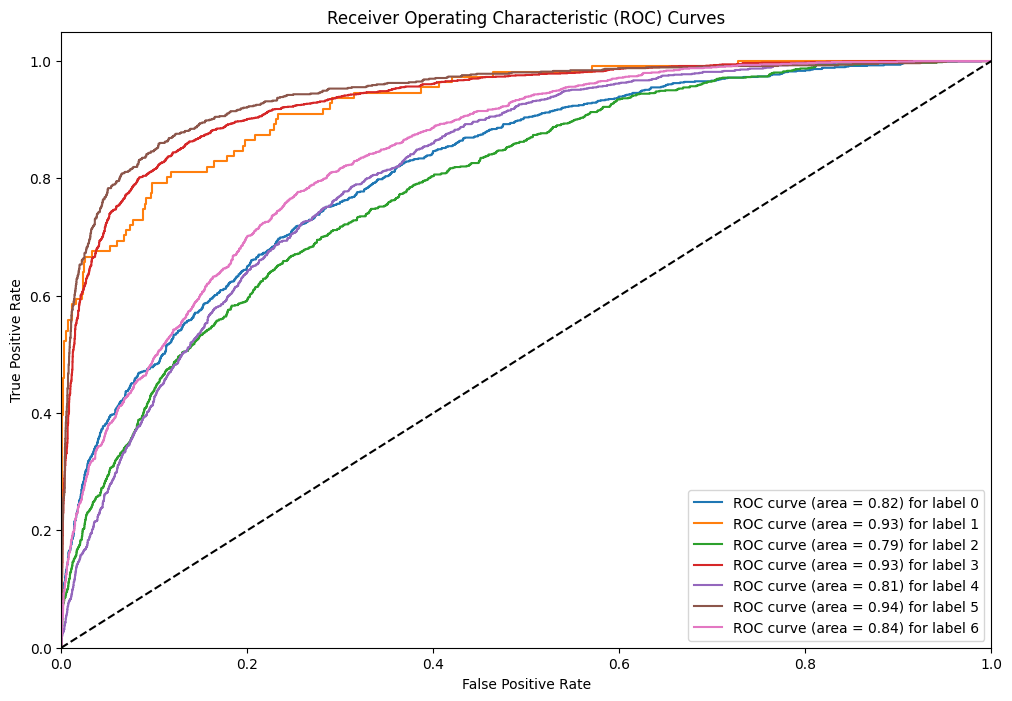

Average AUC: 0.87


In [107]:
# Get model predictions
predictions = model.predict(test_images)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 7

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for label {i}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

avg_auc = np.mean([roc_auc[i] for i in range(n_classes)])
print(f'Average AUC: {avg_auc:.2f}')


The ResNet50 significantly improved the average AUC to 0.86, indicating the best overall performance among all models evaluated.
it also shows substantial improvements in AUC for all classes, with the highest AUC observed for 'Disgust' (0.94) and 'Surprise' (0.93).
also improved the balance between classes, as indicated by the reduced gap between the highest and lowest AUC values. This suggests that the ResNet50 model is more consistent in predicting different emotions, effectively addressing class imbalance.

225/225 [==============================] - 1s 6ms/step
Precision: [0.43419789 0.48091603 0.44946809 0.81900452 0.4458457  0.72570726
 0.45407503]
Recall: [0.47181628 0.56756757 0.33007812 0.71420519 0.4819567  0.70998797
 0.56934307]
F1-score: [0.45222611 0.52066116 0.38063063 0.76302319 0.46319846 0.71776156
 0.5052177 ]


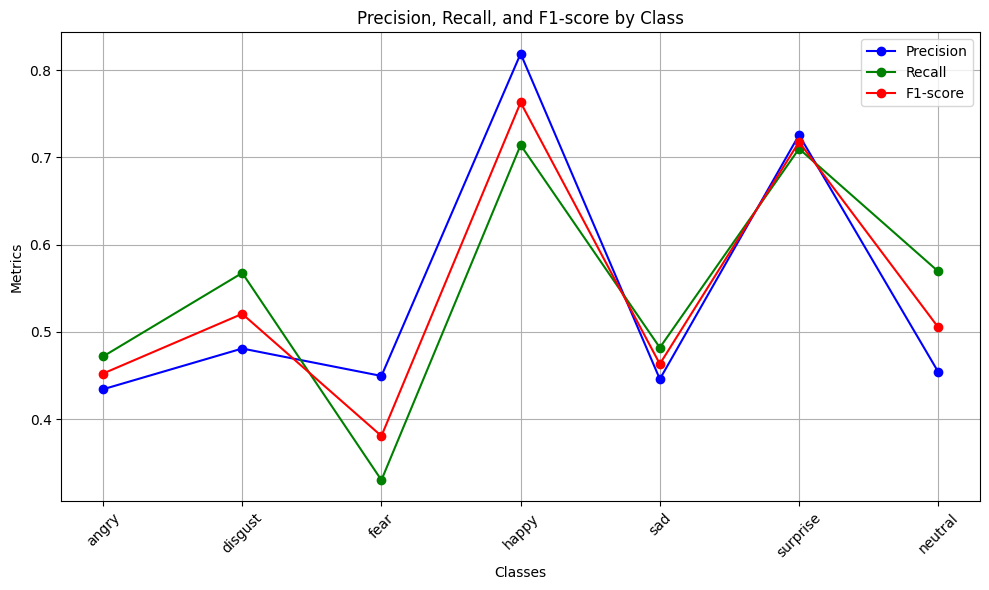

In [108]:
emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
predictions = model.predict(test_images)
true_labels = np.argmax(test_labels, axis=1)
predicted_labels = np.argmax(predictions, axis=1)

precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1_score = f1_score(true_labels, predicted_labels, average=None)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)
plt.figure(figsize=(10, 6))

plt.plot(emotions, precision, marker='o', label='Precision', color='blue')
plt.plot(emotions, recall, marker='o', label='Recall', color='green')
plt.plot(emotions, f1_score, marker='o', label='F1-score', color='red')

plt.title('Precision, Recall, and F1-score by Class')
plt.xlabel('Classes')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

The graph illustrates the precision, recall, and F1-score for each class in a multi-class classification problem. Precision (blue line) measures the exactness of the classifier, recall (green line) measures its completeness, and the F1-score (red line) balances precision and recall. The "Happy" class shows the best performance with high precision, recall, and F1-score, indicating that the classifier is effective in identifying this emotion. The "Surprise" class also performs well, with all metrics above 0.55. In contrast, the "Fear" and "Disgust" classes exhibit the lowest performance, particularly in recall, suggesting the model struggles to correctly identify these emotions. The "Neutral" class shows balanced but low metrics, indicating difficulty in distinguishing this emotion.

# Align Faces

Insted of making our model smarter , can we make the task easier ?



---

Now we will align the faces using the function 'align_face' on the dataset after applying SMOTE algorithm ,hoping to see any  improvments


In [109]:
def process_data_chunk(chunk_df, pixel_columns):
    aligned_images = []
    labels = []

    for j in range(len(chunk_df)):
        image_vector = chunk_df.iloc[j][pixel_columns].values
        aligned_face = align_face(image_vector, 48, 48)
        aligned_images.append(aligned_face)

    aligned_images_array = np.array(aligned_images)
    labels_one_hot = chunk_df.iloc[:, -1].values

    return pd.DataFrame({ 'Aligned Images': aligned_images_array.tolist(), 'Labels': labels_one_hot.tolist() })

def process_data_in_chunks(preprocess_train_df, pixel_columns, chunk_size=500):
    processed_chunks = []

    for i in range(0, len(preprocess_train_df), chunk_size):
        chunk_df = preprocess_train_df[i:i + chunk_size]
        processed_chunk = process_data_chunk(chunk_df, pixel_columns)
        processed_chunks.append(processed_chunk)

    # Concatenate processed chunks into a single DataFrame
    processed_data_df = pd.concat(processed_chunks, ignore_index=True)

    return processed_data_df



Processing the entire dataset without chunking would exceed our memory capacity. By dividing the data into smaller chunks, we can handle it more efficiently. Additionally, parallel processing significantly speeds up the process. Without parallelization, the processing would take approximately 10 hours, whereas using parallel processing reduces this time substantially.



In [110]:
def process_data_chunk_parallel(chunk_df, pixel_columns):
    def process_row(row, pixel_columns):
        image_vector = row[pixel_columns].values
        aligned_face = align_face(image_vector, 48, 48)
        return aligned_face.tolist(), row.iloc[-1]

    processed_data = Parallel(n_jobs=-1)(delayed(process_row)(row, pixel_columns) for _, row in chunk_df.iterrows())
    aligned_images, labels = zip(*processed_data)

    return pd.DataFrame({'Aligned Images': aligned_images, 'Labels': labels})

def process_data_in_chunks_parallel(preprocess_train_df, pixel_columns, chunk_size=500):
    processed_chunks = []

    for i in range(0, len(preprocess_train_df), chunk_size):
        chunk_df = preprocess_train_df[i:i + chunk_size]
        processed_chunk = process_data_chunk_parallel(chunk_df, pixel_columns)
        processed_chunks.append(processed_chunk)

    processed_data_df = pd.concat(processed_chunks, ignore_index=True)

    return processed_data_df


In [111]:

aligned_df = process_data_in_chunks_parallel(preprocess_train_df, pixel_columns)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Adjusting the shape of the base to enable the execution of the extract_hog_features function.

In [ ]:
aligned_df2 = aligned_df
for i in range(48*48):
    aligned_df2[f'pixel_{i}'] = [row[i] for row in aligned_df['Aligned Images'].tolist()]


In [113]:
aligned_df2 = aligned_df2.drop(columns=['Aligned Images'])


In [114]:
X = aligned_df2.drop('Labels', axis=1).values
y = aligned_df2['Labels'].values

In [115]:
hog_features = extract_hog_features(X)

/usr/local/lib/python3.10/dist-packages/skimage/feature/_hog.py:188: RuntimeWarning: invalid value encountered in sqrt
  image = np.sqrt(image)


In [116]:
nan_values = np.isnan(hog_features).any()
print(f"Does hog_features contain NaN values? {nan_values}")


Does hog_features contain NaN values? True


Unfortunately , hog_features contains NaN values, rendering it unsuitable for use with the MultinomialNB and SVM classifiers. The presence of NaN suggests that the face's straightness posed challenges in feature extraction.



---

Now, we will run the RESNET50 model on the database.


In [191]:
X_train, _ = preprocess_train_data(aligned_df, aligned_df.columns,True)
_, y_train = preprocess_train_data(preprocess_train_df, pixel_columns)
X_train_rgb = np.array([convert_grayscale_to_rgb(img) for img in X_train])
X_train_rgb_normalized = X_train_rgb / 255.0
train_generator = datagen.flow(X_train_rgb_normalized, y_train, batch_size=32)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [200]:
model = build_and_compile_model()
history = model.fit(train_generator, epochs=5)

Epoch 1/5
1577/1577 [==============================] - 100s 44ms/step - loss: 2.1119 - accuracy: 0.1827
Epoch 2/5
1577/1577 [==============================] - 69s 44ms/step - loss: 1.8896 - accuracy: 0.2097
Epoch 3/5
1577/1577 [==============================] - 68s 43ms/step - loss: 1.8845 - accuracy: 0.2139
Epoch 4/5
1577/1577 [==============================] - 67s 43ms/step - loss: 1.8737 - accuracy: 0.2186
Epoch 5/5
1577/1577 [==============================] - 69s 44ms/step - loss: 1.8553 - accuracy: 0.2351



Unfortunately, our results fell significantly short of our expectations, yielding an accuracy of 0.3 compared to 0.66 with the database that lacked facial alignment. This discrepancy may be attributed to the rudimentary method we used for facial alignment. We relied on simple adjustments, such as positioning the eyes in a specific spot within the image. In some cases, this process led to image reduction and filling the remaining pixels with black, resulting in a loss of valuable information.



---

let's evaluate our model

In [201]:
test_images, test_labels = preprocess_test_data(test_df)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_images, test_labels)

print("Test Accuracy:", accuracy)

898/898 [==============================] - 8s 8ms/step - loss: 2.7187 - accuracy: 0.1232
Test Accuracy: 0.12316694855690002


898/898 [==============================] - 7s 6ms/step


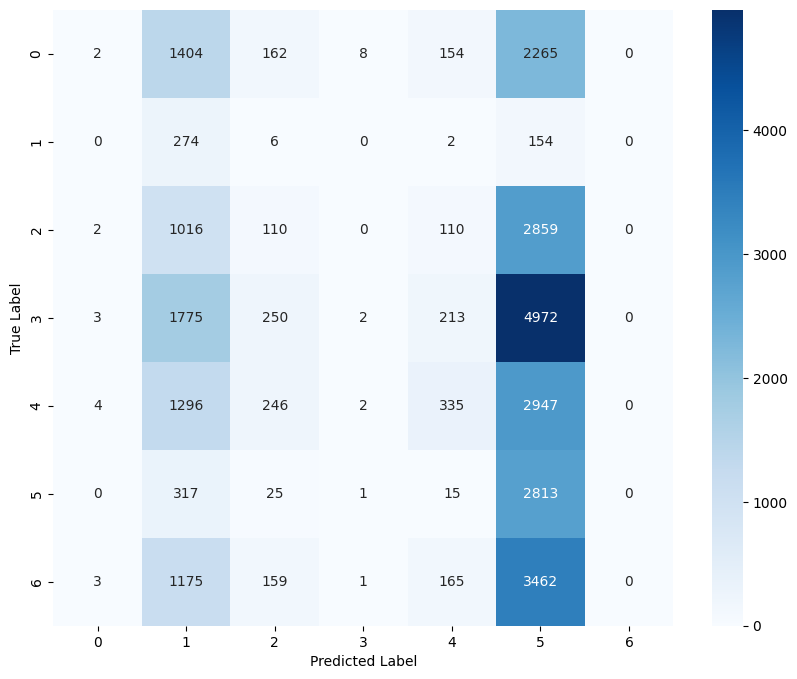

In [202]:
plot_confusion_matrix(model, test_images, test_labels)

The third column is in a dark color, indicating that for each class, most of the samples were misclassified into the "surprise" class. Unfortunately, we got less satisfactory results than the results we obtained from a database that did not undergo face alignment.

898/898 [==============================] - 5s 6ms/step


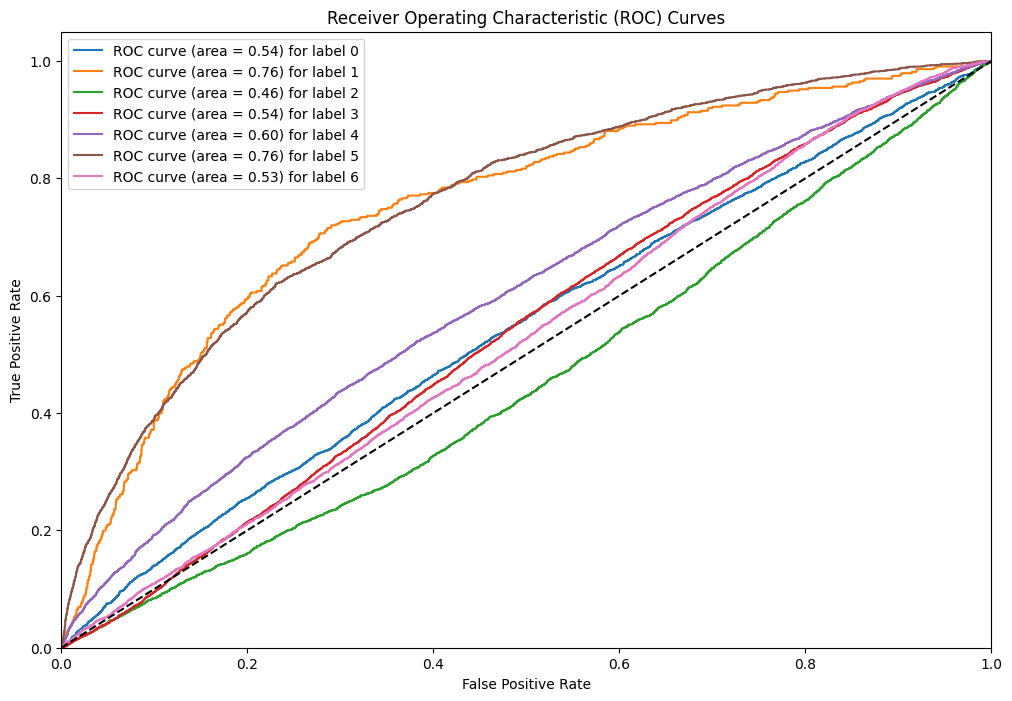

Average AUC: 0.60


In [203]:
# Get model predictions
predictions = model.predict(test_images)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 7

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for label {i}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

avg_auc = np.mean([roc_auc[i] for i in range(n_classes)])
print(f'Average AUC: {avg_auc:.2f}')


The provided ROC curves plot represents the performance of a classifier for multiple labels, with each curve showing the True Positive Rate (TPR) against the False Positive Rate (FPR). The diagonal line represents a random classifier with no discriminatory power. The Area Under the Curve (AUC) values for each label range from 0.46 to 0.76, indicating varying levels of discriminatory ability. Label 2 "fear" has the lowest AUC (0.46), suggesting poor performance, while labels 1 "angry" and 5 "sad" have the highest AUCs (0.76), indicating relatively better performance. The average AUC is 0.60, showing some improvement over random guessing but still not ideal.

This analysis demonstrates that aligning the faces caused a decrease in data quality

# **Balancing the dataset by generating cartoon images from existing samples**



Our primary challenge with the database is the imbalance among the different categories. Our objective is to identify the most effective method to balance the data. To achieve this, we will now explore an alternative approach to SMOTE.


Our goal is to improve accuracy and achieve better results. At this stage, we are balancing the data by creating cartoon images from existing samples instead of using SMOTE. We chose this method for several reasons:

1.   Unlike SMOTE, cartoon images do not introduce noise.
2.   Unlike duplicating existing samples, this method preserves some variation
     in the samples, which is crucial for avoiding the problem of overfitting.

let's first preprocess the data

In [123]:
image_paths = train_df['image_path'].values
X = load_and_preprocess_images(image_paths)
y = train_df['label'].values

train_df = pd.DataFrame(X, columns=[f"pixel_{i}" for i in range(X.shape[1])])
train_df['label'] = y

Let's visualize an image alongside its cartoon version

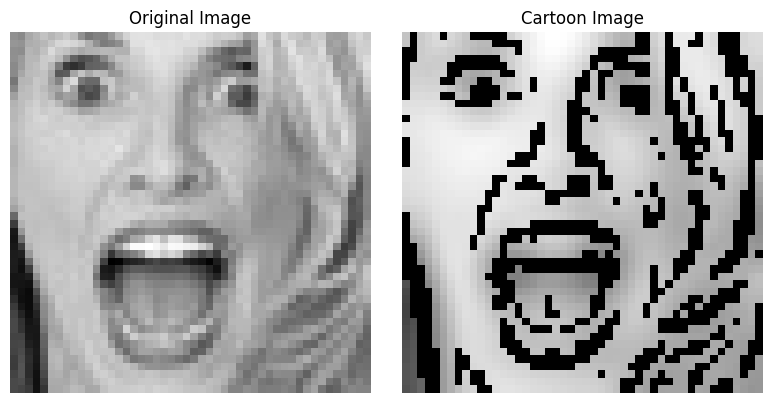

In [124]:
sample = train_df.iloc[1]
image_vector = sample.iloc[:-1]
img = np.array(image_vector).reshape((48, 48)).astype(np.uint8)

edges = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 5, 5)
color = cv2.bilateralFilter(img, 9, 250, 250)
cartoon = cv2.bitwise_and(color, color, mask=edges)


fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(img, cmap='gray')
axs[0].axis("off")
axs[0].set_title("Original Image")

# Display the cartoon image
axs[1].imshow(cartoon, cmap='gray')
axs[1].axis("off")
axs[1].set_title("Cartoon Image")


plt.tight_layout()
plt.show()

Now we will balance the categories by generating cartoon images from existing samples

In [125]:
def get_max_samples(train_df):
    max_samples = train_df['label'].value_counts().max()
    return max_samples

def create_cartoon_samples(train_df, max_samples):
    augmented_data = []

    for category in train_df['label'].unique():
        original_samples = train_df[train_df['label'] == category]
        num_to_generate = max_samples - len(original_samples)

        if num_to_generate > 0:
            for _ in range(num_to_generate):
                sample = original_samples.sample(n=1).iloc[0]
                image_vector = sample.iloc[:-1]

                image_height = 48
                image_width = 48
                img = np.array(image_vector).reshape((image_height, image_width)).astype(np.uint8)


                edges = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 5, 5)
                color = cv2.bilateralFilter(img, 9, 250, 250)
                cartoon = cv2.bitwise_and(color, color, mask=edges)

                cartoon_vector = cartoon.flatten()
                cartoon_sample = cartoon_vector.tolist() + [category]

                augmented_data.append(cartoon_sample)

    augmented_df = pd.DataFrame(augmented_data, columns=train_df.columns[:-1].tolist() + ['label'])
    balanced_df = pd.concat([train_df, augmented_df], ignore_index=True)

    return balanced_df

max_samples = get_max_samples(train_df)

# Create cartoon samples to balance the categories
balanced_train_df = create_cartoon_samples(train_df, max_samples)
#print(len(balanced_train_df))
balanced_train_df = balanced_train_df.sample(frac=1, random_state=0).reset_index(drop=True)




Now we will extract the features using HOG and then run the two NB and SVM algorithms

In [126]:
X1 = balanced_train_df.drop('label', axis=1).values
y1 = balanced_train_df['label'].values

In [127]:
hog_features = extract_hog_features(X1)

let's preprocess the test data :

In [128]:
X_test1 , y_test1= preprocess_test_data2(test_df)
X_test_hog1 = extract_hog_features(X_test1)

In [204]:
X_train, y_train = preprocess_train_data(balanced_train_df, pixel_columns)
X_train_rgb = np.array([convert_grayscale_to_rgb(img) for img in X_train])
X_train_rgb_normalized = X_train_rgb / 255.0
train_generator = datagen.flow(X_train_rgb_normalized, y_train, batch_size=32)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# **MultinomialNB algorithm**

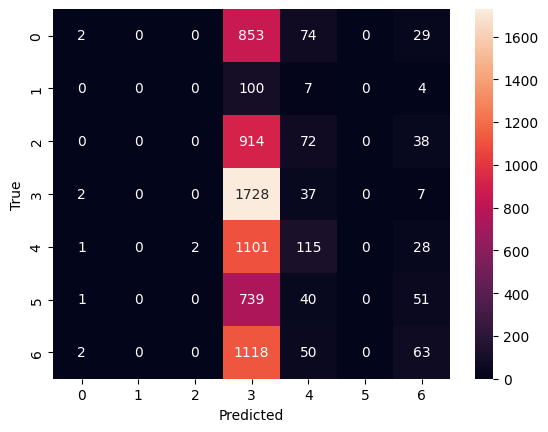

Accuracy: 0.2658122039565339


In [130]:
clf = MultinomialNB()
clf.fit(hog_features, y1)
y_pred = clf.predict(X_test_hog1)
cm = confusion_matrix(y_test1.argmax(axis=1), y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_df['label'].unique(), yticklabels=test_df['label'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print(f'Accuracy: {accuracy_score(y_test1.argmax(axis=1), y_pred)}')

It appears that using NB on the dataset balanced with SMOTE resulted in better performance (0.38) compared to balancing with cartoon images (0.26) when running NB.

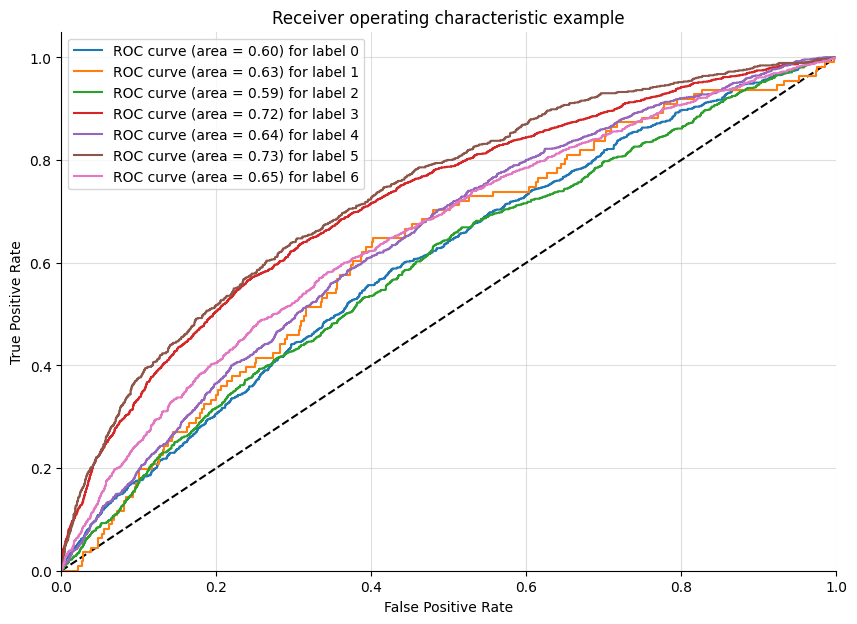

Average AUC: 0.65


In [131]:
y_prob = clf.predict_proba(X_test_hog1)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 7
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for label {i}')
ax.legend(loc="best")
ax.grid(alpha=0.4)
sns.despine()
plt.show()

avg_auc = np.mean([roc_auc[i] for i in range(n_classes)])
print(f'Average AUC: {avg_auc:.2f}')


You can observe that according to the ROC AUC index, the results after applying the Naive Bayes model on data balanced using cartoon images are worse compared to the results obtained by balancing the data using SMOTE. Specifically, the Naive Bayes model showed significantly lower AUC values across most classes.

However, in the Naive Bayes model, the 'Happy' and 'Surprise' classes led to better results compared to the other classes, indicating that these particular emotions were easier for the model to classify accurately.

Given that Naive Bayes is a relatively simple model, it’s essential to examine the performance of a more complex model like SVM (Support Vector Machine). Let’s evaluate SVM in the next section to see if it offers any improvements in classification performance

# **SVM**

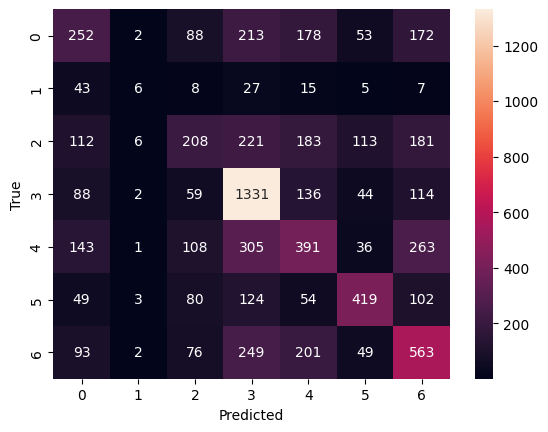

Accuracy: 0.4416271942045138


In [132]:
# Train the SVM on the HOG features
clf = svm.SVC(kernel='linear', C=1.0, probability=True)
clf.fit(hog_features, y1)
y_pred = clf.predict(X_test_hog1)
cm = confusion_matrix(y_test1.argmax(axis=1), y_pred)

sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_df['label'].unique(), yticklabels=test_df['label'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(f'Accuracy: {accuracy_score(y_test1.argmax(axis=1), y_pred)}')

It seems that both using SVM on the dataset balanced with SMOTE and balancing with cartoon images resulted in the same accuracy of 0.44 -
SVM is often considered a more powerful algorithm compared to Naive Bayes ,
SVM is known for its ability to handle complex decision boundaries and high-dimensional data. It works by finding the hyperplane that best separates different classes in the feature space. This can be advantageous for our task where the relationships between features and emotions may be nonlinear

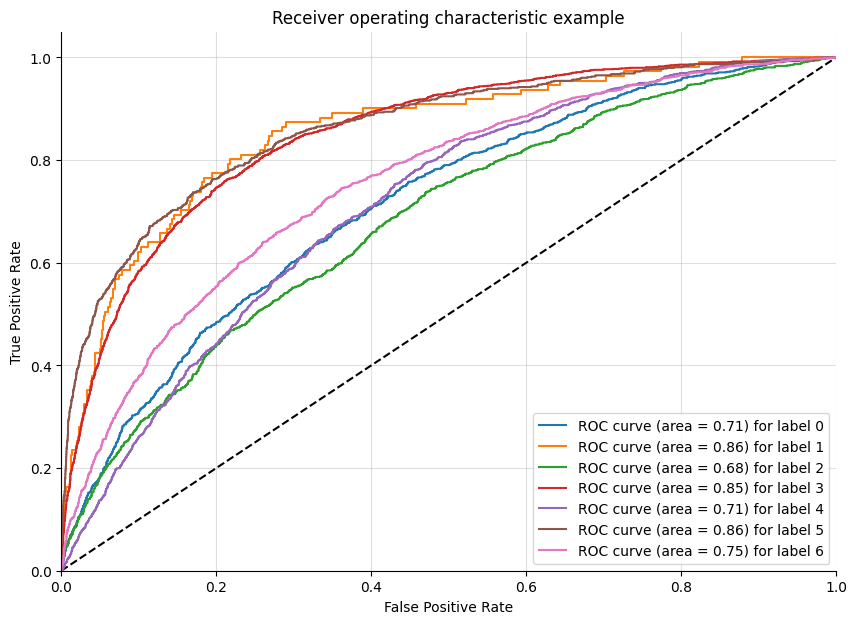

Average AUC: 0.78


In [133]:
y_prob = clf.predict_proba(X_test_hog)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 7
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for label {i}')
ax.legend(loc="best")
ax.grid(alpha=0.4)
sns.despine()
plt.show()

avg_auc = np.mean([roc_auc[i] for i in range(n_classes)])
print(f'Average AUC: {avg_auc:.2f}')


We can see that there is a match between the ROC and accuracy indices since in both we obtained identical results, with an average AUC of 0.78. This consistency across different evaluation metrics indicates that the performance of the SVM model is equally good according to both ROC and accuracy indices. This alignment confirms that the method of data balancing, whether using SMOTE or cartoon images, did not significantly affect the SVM model's ability to classify the emotions accurately.

SVMs are robust to noise and handle similar data points well by focusing on finding the optimal hyperplane that separates different classes with the maximum margin. This allows SVM to maintain performance even with redundant or slightly varied data, such as the similar samples produced by the CARTOON IMAGES. This explains why SVM showed consistent performance across both SMOTE and CARTOON IMAGES balanced datasets, while NB and RESNET50 performed better with the more diverse samples provided by SMOTE

# **ResNet50**

In [184]:
test_images, test_labels = preprocess_test_data(test_df)

In [205]:
test_images, test_labels = preprocess_test_data(test_df)
test_generator = datagen.flow(test_images, test_labels, batch_size=32)

In [ ]:
model = build_and_compile_model()
history = model.fit(train_generator, epochs= 10, validation_data=test_generator)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1577/1577 ━━━━━━━━━━━━━━━━━━━━ 114s 39ms/step - accuracy: 0.1691 - loss: 2.5600 - val_accuracy: 0.1701 - val_loss: 2.2542
Epoch 2/10
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.3576 - loss: 1.6233 - val_accuracy: 0.2799 - val_loss: 1.9237
Epoch 3/10
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.4605 - loss: 1.3771 - val_accuracy: 0.4365 - val_loss: 1.4503
Epoch 4/10
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.5054 - loss: 1.2562 - val_accuracy: 0.4202 - val_loss: 1.4944
Epoch 5/10
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.5012 - loss: 1.3002 - val_accuracy: 0.4416 - val_loss: 1.3982
Epoch 6/10
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.5486 - loss: 1.1468 - val_accuracy: 0.4342 - val_loss: 1.5734
Epoch 7/10
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.5851 - loss: 1.0579 - val_accuracy: 0.4935 - val_loss: 1.3083
Epoch 8/10
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.5997 - loss: 1.0

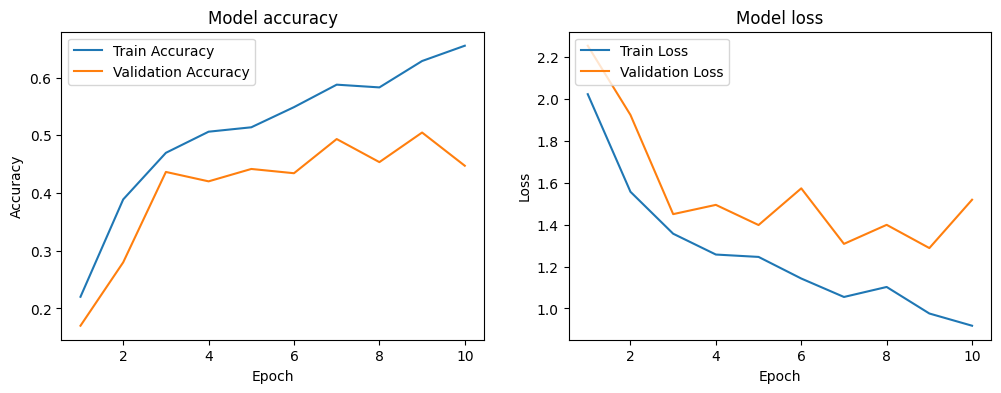

In [ ]:
epochs = np.arange(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Train Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

Our results improved compared to when we used SMOTE, achieving an accuracy of
0.75 instead of 0.68.

let's evaluate the model on the test data

In [ ]:
loss, accuracy = model.evaluate(test_images, test_labels)

print("Test Accuracy:", accuracy)

225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.4768 - loss: 1.4283
Test Accuracy: 0.4471997916698456



We achieved an accuracy of 0.56 on the test data. This indicates that while our accuracy on the training data improved, the test data accuracy remained the same compared to the accuracy we obtained using SMOTE, leading to an increase in overfitting.

Our explanation for this phenomenon is that the samples in the current training set are more similar to each other compared to the diverse samples generated by SMOTE, where new samples are created by interpolating between several existing samples. This similarity in the training set reduces its generalizability, causing overfitting and poorer performance on the test data.

225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step


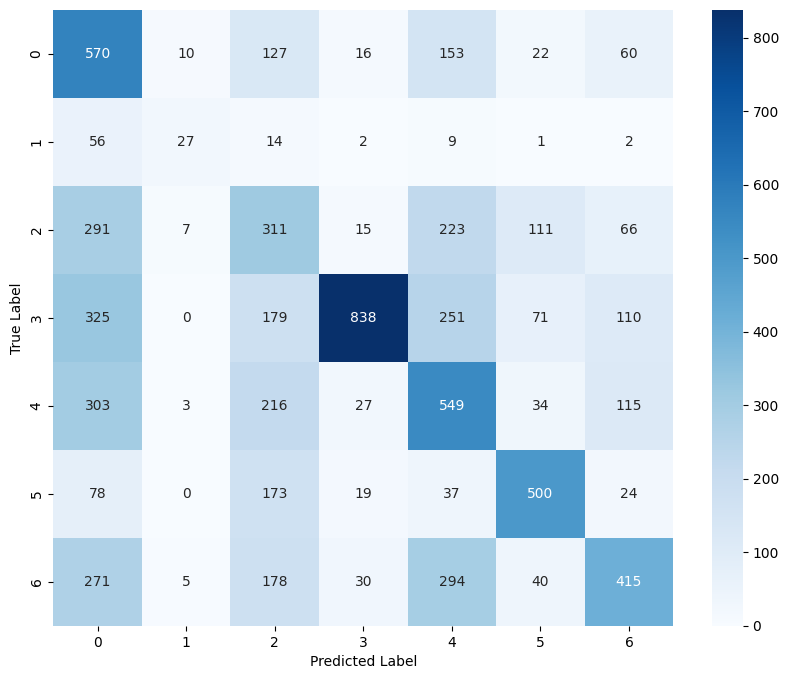

In [ ]:
plot_confusion_matrix(model, test_images, test_labels)

You can see that compared to the database that went through SMOTE, the accuracy decreased in every class except for the two classes "happy" and "natural." These two classes contain the most samples in the original database, so we added fewer samples to them using the cartoon method to achieve balance. This suggests that the model trained on data that passed SMOTE has better generalization ability. The samples in the current training set are more similar to each other compared to the diverse samples generated by SMOTE, where new samples are created by interpolating between several existing samples. This similarity in the training set reduces its generalizability, causing overfitting and poorer performance on the test data.

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


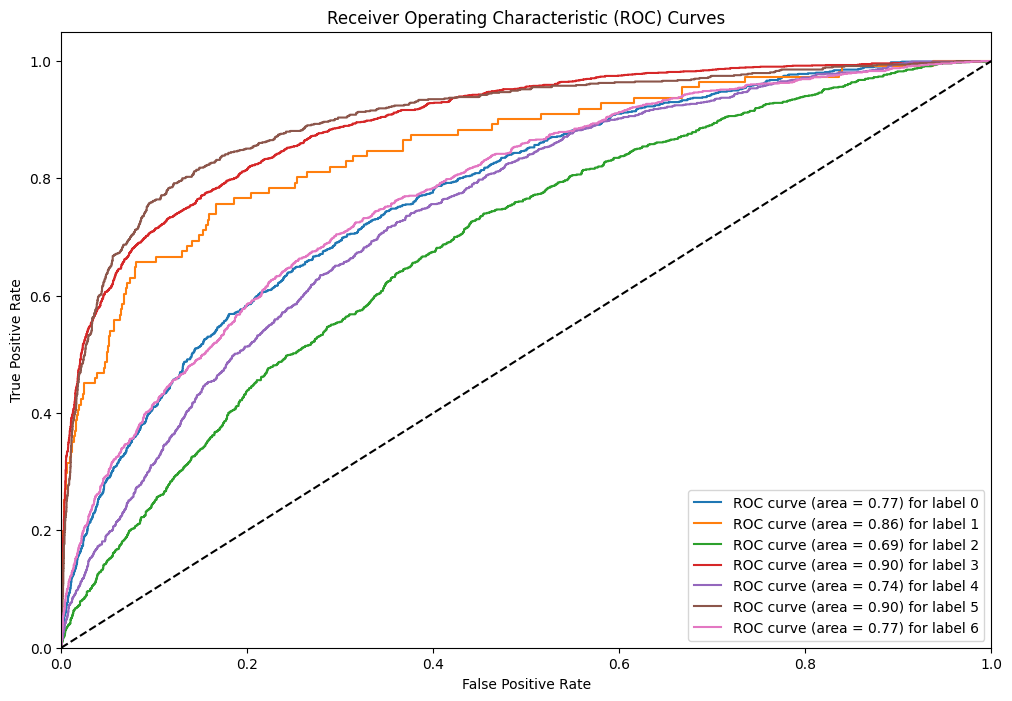

Average AUC: 0.80


In [ ]:
# Get model predictions
predictions = model.predict(test_images)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 7

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for label {i}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="best")
plt.show()

avg_auc = np.mean([roc_auc[i] for i in range(n_classes)])
print(f'Average AUC: {avg_auc:.2f}')


In the ResNet50 model, balancing the data using SMOTE provided better results with an average AUC of 0.86 compared to 0.82 for the data balanced using cartoon images. This suggests that SMOTE was more effective in improving the model's performance. The better performance of SMOTE can be attributed to its ability to create synthetic samples that better represent the distribution of the minority class, leading to improved generalization of the model


---



**In our analysis of all models, the least favorable results consistently appeared in detecting fear from the data. This highlights the challenge even for humans in identifying this emotion from images. To illustrate, we will present some images where identifying this emotion proves particularly difficult**

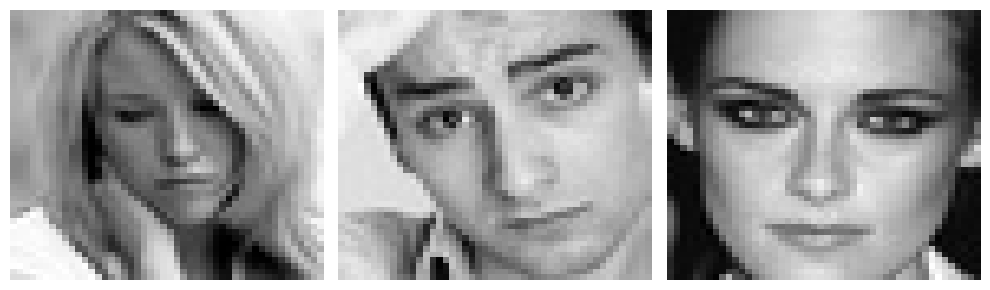

In [153]:
train_dir = "/content/train"
train_df = create_dataframe(train_dir)

fig, axes = plt.subplots(1, 3, figsize=(10, 3))

image_path = train_df[train_df['label'] == 2].iloc[5]['image_path']
image = io.imread(image_path)
axes[0].imshow(image, cmap='gray')
axes[0].axis('off')
axes[0].set_aspect('auto')


image_path = train_df[train_df['label'] == 2].iloc[13]['image_path']
image = io.imread(image_path)
axes[1].imshow(image, cmap='gray')
axes[1].axis('off')
axes[1].set_aspect('auto')


image_path = train_df[train_df['label'] == 2].iloc[17]['image_path']
image = io.imread(image_path)
axes[2].imshow(image, cmap='gray')
axes[2].axis('off')
axes[2].set_aspect('auto')


plt.tight_layout()
plt.show()

Research suggests that the experience of fear can vary significantly based on cultural context, leading to diverse expressions that symbolize this emotion. This variability complicates the identification of fear from facial expressions across different populations.

articles that support the idea that the feeling of fear varies across cultures and affects facial expressions:

[Facial expressions—including fear—may not be as universal as we thought](https://www.science.org/content/article/facial-expressions-including-fear-may-not-be-universal-we-thought)

[Fear Facial Expressions: Basic or Social Constructivist?](https://psu.pb.unizin.org/psych425/chapter/facial-expressions-of-feabasic-or-social-constructivist/)

As we saw before, these are the results of the clusering using the hog extracted features after applying SMOTE on the data set.


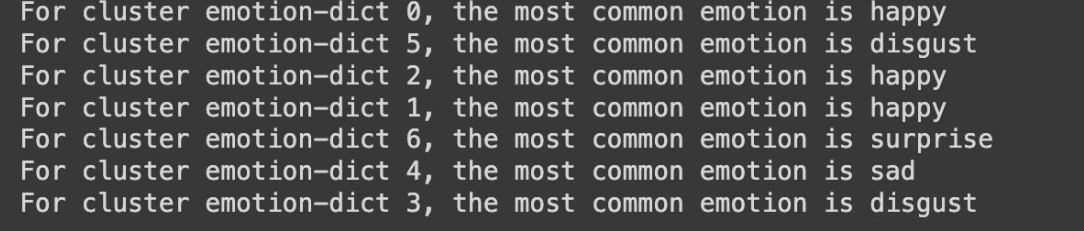


The clustering results reveal that the emotions "happy," "disgust," "surprise," and "sad" are distinctly represented in our dataset, as evidenced by their dominance in multiple clusters. Specifically, "happy" is prevalent in clusters 0, 1, and 2; "disgust" in clusters 3 and 5; "surprise" in cluster 6; and "sad" in cluster 4. This distinct clustering aligns with the high performance of our classification algorithms for these emotions, suggesting that they possess unique features that are easily identifiable by the models. The consistent representation of these emotions across both clustering and classification indicates a balanced dataset and robust algorithmic capability..

# **Findings and Interpretation**



The times displayed in the tables represent the execution durations on A100 GPU hardware. This setup offers a substantial performance boost compared to executing the same code on a CPU.

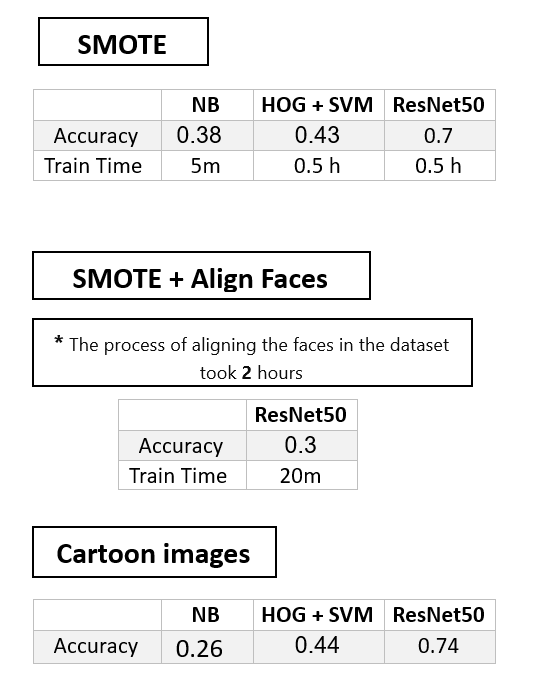



*   Naive Base without SMOTE on HOG features -
 Accuracy : 0.36 , AUC(Area under the curve) = 0.73
 We got a relatively low accuracy. The purpose of this algorithm was to make a preliminary assessment for the emotion prediction task .
 This model predicted most of the samples as "happy" and this indicated to us the need to balance the data.


*   Naive base without SMOTE on VGG features -
Accuracy : 0.43 , AUC(Area under the curve) = 0.77
This model showed a notable improvement compared to the previous one. The EDA  revealed that VGG features encompass the mouth and eye areas, which are critical for better representing emotions. As a result, the accuracy and AUC scores were higher.


*   Naive Base with SMOTE on HOG -
 Accuracy: 0.38 , AUC = 0.71
Comparing this model with the first Naive Bayes model, we see that using SMOTE to balance the dataset improved the correct prediction rate for each class. This balanced data led to less biased classifications and a slight improvement in accuracy.


*   SVM (support vector machine) with SMOTE on HOG
 Accuracy : 0.43 , AUC(Area under the curve) = 0.78
The SVM model with SMOTE on HOG features showed further improvement, as expected. SVM is a more sophisticated algorithm compared to Naive Bayes, which contributed to better performance.

*   RESNET50 with SMOTE -
 Accuracy: 0.54 , AUC = 0.86
This model achieved the best results among all previous models. Deep neural networks, particularly complex architectures like RESNET50, are adept at handling intricate problems, resulting in significantly higher accuracy and AUC

*   RESNET50 – aligned faces with SMOTE
Accuracy: 0.42 , AUC = 0.6
In an attempt to improve data quality, we aligned the faces to facilitate better feature learning by the network. However, this led to less favorable results. The face alignment process itself is complex and our naive implementation caused loss of information (e.g., shrinking images and painting black pixels), which adversely affected the performance.

*   Naive base on cartoon images on HOG features-
 Accuracy : 0.26 , AUC = 0.65
Initial data analysis revealed a class imbalance in the emotion categories. To address this, we experimented with creating cartoon samples from existing images to balance the data, instead of using SMOTE. This approach resulted in low accuracy, likely due to the cartoon samples being too similar to the original ones, reducing data variability.

*   SVM on cartoon on HOG-
 Accuracy: 0.44 , AUC: 0.78
The SVM model, when applied to the cartoon-balanced data, achieved similar results to the SMOTE-balanced data. This underscores SVM's robustness in handling different data balancing techniques better than Naive Bayes.


*   RESNET50 + cartoon-
 Accuracy: 0.48 , AUC: 0.82
RESNET50 consistently outperformed both SVM and Naive Bayes on the same datasets. The results indicate that deep networks like RESNET50 benefit more from SMOTE-balanced data compared to the cartoon method, suggesting that SMOTE is a more effective balancing technique.


---




The face alignment algorithm yielded suboptimal results, resulting in a failure to align the faces accurately. We resorted to a simple and unsophisticated algorithm due to the unavailability of structured alternatives. Consequently, we refrained from running the SVM and MNB classifiers on the base post-alignment, as feature extraction using HOG proved unattainable. Our preference was to extract features using this method for a fair comparison in the end.

Notably, employing SMOTE to balance the data produced the most favorable outcomes, underscoring the significance of data variation. Balancing via cartoon image generation yielded inferior results compared to SMOTE, as previously discussed.

Moreover, it's evident that RESNET50 outperforms SVM and NB classifiers concerning the same database, underscoring the efficacy of sophisticated networks of this nature

# **Challenges**

Initially, we started working on Kaggle due to the convenience of importing databases directly. However, we faced significant issues with collaboration, as the platform did not support simultaneous editing of the notebook, leading to synchronization problems.

To address this, we switched to Google Colab, which allowed us to work concurrently on the notebook, greatly enhancing our collaborative efficiency. Nonetheless, as our project progressed, we encountered substantial limitations:

Memory Constraints: The limited memory availability on Colab hindered our ability to process larger datasets effectively.
GPU Usage Limits: The restricted time allocation for using the GPU in the free version of Colab significantly impeded our progress. Some algorithms required extensive computational resources and took more than 6 hours to run on a CPU, which was impractical for our needs.
To overcome these obstacles, we opted to upgrade to Colab Pro+, which provided us with unlimited GPU access. This upgrade was essential for maintaining our workflow's efficiency and ensuring that our computational needs were met without interruptions.

# **Improvement ideas**



1.   Train a facial alignment model ourselves based on a labeled database and then use the algorithm we built.


2.   Try to balance the data by merging several databases.



# **Self reflection**

We thoroughly enjoyed working on this project. It was both challenging and rewarding to learn new algorithms and fill in the gaps in our knowledge to accomplish the required tasks. Throughout the process, we encountered numerous ideas, some of which proved to be successful and were included in the final project, while others did not work out and were subsequently excluded.

We found the journey engaging, particularly the trial-and-error approach, as it allowed us to explore what worked and what needed to be changed. At each stage, we held specific views and, after completing each phase, we analyzed why we believed it worked or did not. This iterative process was crucial in refining our understanding and improving our results.

Additionally, we experienced firsthand the importance of advanced hardware and the efficiency of existing libraries. Without these resources, the algorithms took an unreasonable amount of time to execute, and we occasionally faced seemingly insurmountable obstacles. This highlighted the critical role that hardware and software optimization play in the successful implementation of complex algorithms.









---

# **:):**
  *It's about how you choose to look at it, or about which emotion recognition algorithm you use*


---



# **Thank you for the opportunity to explore the world of Data Science :)**